# ContactTracing tutorial

This pipeline uses annotated and filtered single-cell data, as well as a database of ligand/receptors, to find detect putative interactions in which:
- the ligand is differentially expressed in one cell type between two conditions
- the expression of the receptor produces an 'interaction effect', characterized by a condition-specific transcriptional response to receptor expression

To start, you need to set these variables in the following code block:
- `anndata_file`: path to h5ad file containing the anndata object with scRNA-seq data
    - The object should have a layer called 'logX' with log-normalized counts
        - We normalize each cell to sum to 10000, then log transform with: np.log10(X + 0.1) - np.log10(0.1). (It is assumed this normalization is already done)
    - It should have a column .obs['cell type'] with clean cell type annotations (mis-annotated cells may produce spurious results)
    - It should have a columns .obs['sample'] with sample name
    - It should have a column .obs['condition'] with condition, we need two conditions to compare (other cells will be ignored). The condition names should be simple (characters should be alphanumeric, underscore, or period, should start with alphabetic character).
    - The index of the .var matrix should map to gene names used in the interactions file
    - The data set should be filtered for quality cells only with confident cell type annotations, high mitochondrial rate removed, likely doublets removed, etc
- `interactions_file`: text file (tab-delimited) with list of ligands and receptors, should have columns with header 'ligand' and 'receptor' giving ligand/receptor pairs. An example file for mouse can be found in the file `data/interactions_mm10.txt` directory of this tutorial.
- The name of two conditions to compare (`condition1` and `condition2`), tests will compare condition1 vs condition2, so that logFC will be positive when condition1 is up.


__Anndata files used for "Cancer cell non-autonomous tumor progression from chromosomal instability" (Li, Hubisz, Earlie et al) can be found here: 10.5281/zenodo.8061222__

In [1]:
## Set input file names, conditions, and output directories
anndata_file = '/workdir/adata_for_tutorial.h5ad'
interactions_file='/workdir/ContactTracing_tutorial/data/interactions_mm10.txt'
condition1='highCIN'
condition2='lowCIN'

# this should be location of tutorial files/scripts
tutorial_dir='/workdir/ContactTracing_tutorial'

# set output directory
output_dir='/workdir/tutorial_output'

# tmp_output_dir for unimportant/intermediate output
tmp_output_dir=f'{output_dir}/tmp/NOBACKUP'
!mkdir -p {tmp_output_dir}

In [2]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import itertools
import subprocess
import multiprocessing
from multiprocessing import Pool, freeze_support
from functools import partial
from itertools import product
from kneed import KneeLocator
from adjustText import adjust_text
import statsmodels
import sys
import warnings
from sklearn.preprocessing import scale
from IPython.display import Image

In [3]:
sys.path.append(f'{tutorial_dir}/python')

In [4]:
import contactTracing_library as ct

# we use a couple functions from palantir source code
import palantir_functions as palantirFuncs

In [5]:
# this is just for debugging, if any changes are made to ContactTracing_library.py, reload
importlib.reload(ct)

<module 'contactTracing_library' from '/workdir/ContactTracing_tutorial/python/contactTracing_library.py'>

In [6]:
# It seems to be much faster running R with these environment Variables set, surprisingly, turning off multithreading improves runtime more than 2 fold.
Rcommand='MKL_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 OMP_NUM_THREADS=1 R'

## Load data

In [7]:
adata = sc.read(anndata_file)
adata

AnnData object with n_obs × n_vars = 33092 × 16685
    obs: 'totReads', 'doublet_score', 'library_size', 'sample', 'condition', 'batch', 'cell type'
    var: 'gene_ids', 'genome', 'highly_variable', 'humanGene'
    uns: 'cell type_colormap', 'cell type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'X', 'X_impute', 'logX'
    obsp: 'connectivities', 'distances'

__Remove all cells not in condition1 or condition2__

In [8]:
keepData = (adata.obs['condition'] == condition1) | (adata.obs['condition'] == condition2)
print(f'Removing {sum(~keepData)} cells with condition != ({condition1} or {condition2})')
adata = adata[keepData]

Removing 0 cells with condition != (highCIN or lowCIN)


In [9]:
adata.obs['condition'].value_counts()

highCIN    22077
lowCIN     11015
Name: condition, dtype: int64

__Do not allow cell types to have special characters__

The code below replaces spaces and slashes with underscores. Other special characters (quotes, astericks, etc) may also need to be replaced if they are in any cell type name

In [10]:
adata.obs['cell type'] = [x.replace(' ', '_').replace('/', '_') for x in adata.obs['cell type'].astype(str)]
adata.obs['cell type'].value_counts()

/tmp/ipykernel_1428966/1026523196.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell type'] = [x.replace(' ', '_').replace('/', '_') for x in adata.obs['cell type'].astype(str)]


PMN_gMDSC            10650
Macrophages_mMDSC     7502
T_cells               7080
Tumor_cells           3175
B_cells               2014
NK_cells              1306
cDC                    614
pDC                    256
Fibroblast_cells       197
Endothelial_cells      127
Osteoclasts            117
Mast_cells              54
Name: cell type, dtype: int64

__Compute cngeneson, covariate used for MAST__

Represents the scaled number of expressed genes in each cell

In [11]:
adata.obs['cngeneson'] = scale(np.sum(adata.layers['logX'] > 0, axis=1))

__Read interactions file__

In [12]:
interactions = pd.read_csv(interactions_file, sep='\t')
interactions

,ligand,receptor
0,Wnt9a,Egfr
1,Wnt9a,Fzd9
2,Wnt9a,Fzd4
3,Wnt9a,Fzd7
4,Ccl2,Ccr4
...,...,...
1880,F11r,aLb2_complex
1881,NKG2D_II_receptor,Ulbp1
1882,PlexinA1_complex1,Sema6d
1883,PlexinA1_complex2,Sema6d


__Should not have any duplicated interactions; if so, remove__

In [13]:
f = interactions[['ligand', 'receptor']].duplicated()
if sum(f) > 0:
    print(f'Removing {sum(f)} duplicated interactions')
    interactions = interactions.loc[~f]

__Remove any interactions that don't have both genes in adata__

In [14]:
allgenes = list(set(adata.var.index))
f = interactions['ligand'].isin(allgenes) & (interactions['receptor'].isin(allgenes))
print(f'Removing {sum(~f)} interactions that do not have both genes in adata')
interactions = interactions.loc[f]

Removing 0 interactions that do not have both genes in adata


## Find ligands that are differentially expressed in each cell type

In [15]:
mast_outdir=f'{output_dir}/MAST_between_conditions'
!mkdir -p {mast_outdir}

In [16]:
# set this list to all interesting ligand cell types
ligand_cellTypes = list(adata.obs['cell type'].unique())
ligand_cellTypes

['NK_cells',
 'Macrophages_mMDSC',
 'Osteoclasts',
 'Tumor_cells',
 'PMN_gMDSC',
 'T_cells',
 'cDC',
 'B_cells',
 'Fibroblast_cells',
 'pDC',
 'Endothelial_cells',
 'Mast_cells']

__Run MAST on each cell type, comparing the two conditions__

Note: cngeneson is a recommended covariate in this analysis.

You can add other covariates to the analysis by adding them to the --covariates option, as a comma-delimited list. For example, to add sample name, for example, use the argument: --covariates cngeneson,sample. This requires adata.obs['sample'] ato be defined. Note, it will not make sense for sample to be a covariate unless individual samples are represented in both conditions.

You may also want to modify --numcore option to reflect how many cores you want MAST to use in each run

In [17]:
ligands = list(interactions['ligand'].unique())

In [18]:
## Each command will take several minutes (or more, depending on data set size).
## Set this value to False if you prefer to copy commands to a script and run outside the notebook.
runCommands=True

In [19]:
for cellType in ligand_cellTypes:
    outdir=f'{mast_outdir}/{cellType}'
    !mkdir -p {outdir}
    mast_infile = f'{tmp_output_dir}/adata_{cellType}_ligands.h5ad'
    tmp = adata[adata.obs['cell type'] == cellType, ligands].copy()
    tmp.write(mast_infile)
    # note: add --force option here if you want to overwrite previous results and re-run
    cmd=f'{Rcommand} --vanilla --args --infile "{mast_infile}" --outdir "{mast_outdir}/{cellType}" --groups "condition"'
    cmd += f' --covariates cngeneson --numcore 10 --comp-groups {condition1} {condition2}'
    cmd += f' < {tutorial_dir}/R/MAST_wrapper.R'
    if runCommands:
        # Note: if force is false, will not run if stdoutfile exists already 
        # if wait is false, will run commands in background and return to notebook. 
        #    In this case you would want to decrease --numcore in command above, or else server will get overwhelmed
        #    if there are many cell types
        ct.run_in_background(cmd, stdoutfile=f'{outdir}/stdout.txt', quiet=True, wait=True, force=True)
    else:
        print(f'{cmd} &> {outdir}/stdout.txt')

calling bash -c 'MKL_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 OMP_NUM_THREADS=1 R --vanilla --args --infile "/workdir/tutorial_output/tmp/NOBACKUP/adata_NK_cells_ligands.h5ad" --outdir "/workdir/tutorial_output/MAST_between_conditions/NK_cells" --groups "condition" --covariates cngeneson --numcore 10 --comp-groups highCIN lowCIN < /workdir/ContactTracing_tutorial/R/MAST_wrapper.R' > /workdir/tutorial_output/MAST_between_conditions/NK_cells/stdout.txt 2>&1

calling bash -c 'MKL_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 OMP_NUM_THREADS=1 R --vanilla --args --infile "/workdir/tutorial_output/tmp/NOBACKUP/adata_Macrophages_mMDSC_ligands.h5ad" --outdir "/workdir/tutorial_output/MAST_between_conditions/Macrophages_mMDSC" --groups "condition" --covariates cngeneson --numcore 10 --comp-groups highCIN lowCIN < /workdir/ContactTracing_tutorial/R/MAST_wrapper.R' > /workdir/tutorial_output/MAST_between_conditions/Macrophages_mMDSC/stdout.txt 2>&1

calling bash -c 'MKL_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 O

In [20]:
# when MAST commands finished, load results and find DE ligands
# (This code also deletes the temporary adata files)
resultlist = []
for cellType in ligand_cellTypes:
    infile = f'{mast_outdir}/{cellType}/{condition1}_vs_{condition2}.csv'
    if not os.path.exists(infile):
        print(f'{cellType} not done yet')
        continue
    print(f'Removing {tmp_output_dir}/adata_{cellType}_ligands.h5ad')
    os.system(f'rm -f {tmp_output_dir}/adata_{cellType}_ligands.h5ad')
    tmp = ct.read_mast_results(infile)
    tmp['gene'] = tmp.index
    tmp['cell type'] = cellType
    tmp = tmp.loc[[x for x in tmp.index if x in ligands]]
    resultlist.append(tmp)
ligandsDE = pd.concat(resultlist, ignore_index=True)
ligandsDE

Removing /workdir/tutorial_output/tmp/NOBACKUP/adata_NK_cells_ligands.h5ad
Reading /workdir/tutorial_output/MAST_between_conditions/NK_cells/highCIN_vs_lowCIN.csv
Removing /workdir/tutorial_output/tmp/NOBACKUP/adata_Macrophages_mMDSC_ligands.h5ad
Reading /workdir/tutorial_output/MAST_between_conditions/Macrophages_mMDSC/highCIN_vs_lowCIN.csv
Removing /workdir/tutorial_output/tmp/NOBACKUP/adata_Osteoclasts_ligands.h5ad
Reading /workdir/tutorial_output/MAST_between_conditions/Osteoclasts/highCIN_vs_lowCIN.csv
Removing /workdir/tutorial_output/tmp/NOBACKUP/adata_Tumor_cells_ligands.h5ad
Reading /workdir/tutorial_output/MAST_between_conditions/Tumor_cells/highCIN_vs_lowCIN.csv
Removing /workdir/tutorial_output/tmp/NOBACKUP/adata_PMN_gMDSC_ligands.h5ad
Reading /workdir/tutorial_output/MAST_between_conditions/PMN_gMDSC/highCIN_vs_lowCIN.csv
Removing /workdir/tutorial_output/tmp/NOBACKUP/adata_T_cells_ligands.h5ad
Reading /workdir/tutorial_output/MAST_between_conditions/T_cells/highCIN_vs_low

,p,log2FC,ci.hi,ci.lo,fdr,bonferroni,rank_score,FC,scaled_rank_score,abs_scaled_rank_score,gene,cell type
0,1.375397e-11,0.308045,0.390085,0.226005,7.853519e-09,7.853519e-09,81.049357,1.238029,24.966838,24.966838,S100a9,NK_cells
1,1.812972e-10,0.283376,0.368128,0.198624,5.176035e-08,1.035207e-07,69.849728,1.217040,19.793736,19.793736,S100a8,NK_cells
2,3.159667e-04,0.058382,0.089789,0.026974,3.450458e-02,1.804170e-01,7.437226,1.041297,0.434198,0.434198,Ptma,NK_cells
3,9.184356e-04,0.045011,0.067871,0.022152,7.491811e-02,5.244267e-01,2.803152,1.031691,0.126174,0.126174,Lcn2,NK_cells
4,2.908083e-01,0.012923,0.028915,-0.003070,1.000000e+00,1.000000e+00,-0.000000,1.008997,-0.000000,0.000000,aVb3_complex,NK_cells
...,...,...,...,...,...,...,...,...,...,...,...,...
6847,1.000000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,a6b4_complex,Mast_cells
6848,1.000000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,a9b1_complex,Mast_cells
6849,1.000000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,aDb2_complex,Mast_cells
6850,1.000000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,aVb3_complex,Mast_cells


Text(0, 0.5, 'min adjusted p-value')

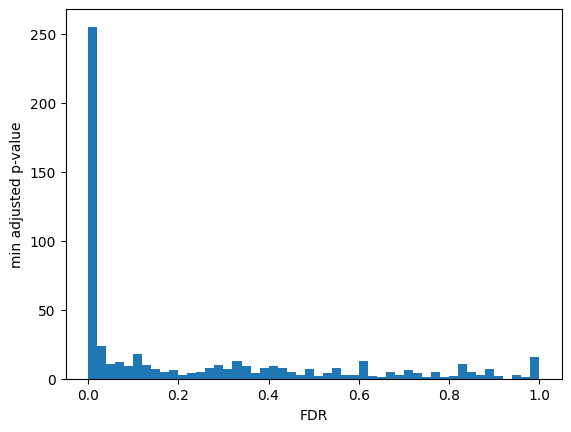

In [21]:
# compute minimum FDR for each ligand across all cell types
minLigandFDR = ligandsDE[['gene', 'fdr']].groupby('gene').min()
plt.hist(minLigandFDR['fdr'], bins=50)
plt.xlabel('FDR')
plt.ylabel('min adjusted p-value')

In [22]:
sigLigands = list(minLigandFDR.loc[minLigandFDR['fdr'] < 0.05].index)
print(f'{len(sigLigands)} out of {len(ligands)} are significantly DE')

283 out of 571 are significantly DE


In [23]:
keepInteractions = interactions['ligand'].isin(sigLigands)
print(f'Keeping {sum(keepInteractions)} out of {interactions.shape[0]} interactions')

Keeping 1011 out of 1885 interactions


In [24]:
interactions = interactions.loc[keepInteractions]

ycol: fdr
Wrote /workdir/tutorial_output/MAST_between_conditions/figures/highCIN_vs_lowCIN_Macrophages_mMDSC.png


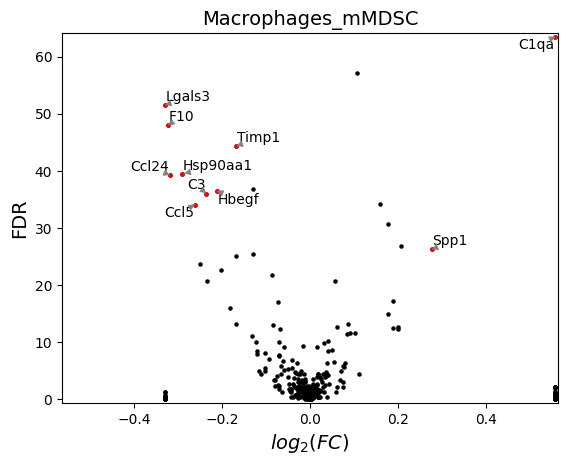

In [25]:
# example plot of MAST results for one cell type
cellType='Macrophages_mMDSC'
# note: this function can take awhile if max_num_label is big
ct.make_volcano_plot(ligandsDE.loc[ligandsDE['cell type'] == cellType], title=cellType, ycol='fdr', label_col='gene',
                     fontsize=10, ylabel='FDR', max_num_label=10,
                     plot_outfile=f'{mast_outdir}/figures/{condition1}_vs_{condition2}_{cellType}.png')

## Run interaction test on receptors associated with DE ligands

This is computationally quite expensive, it can take many minutes per receptor, per cell type. Run-time and memory usage increases with the number of cells. If you use too many cores you may run out of memory and jobs will crash. Some ways to reduce runtime, which are implemented in this notebook, include:
- Only run on cell types / receptors of interest
- Only run on receptors with expression levels above some threshold
- Only run on receptors associated with DE ligands
- Assess interaction effect only in HVGs rather than across genes

In [26]:
# List of cell types that you want to assess interaction effect in
# not necessarily all cell types are of interest
receptor_cellTypes = ['PMN_gMDSC', 'Macrophages_mMDSC', 'T_cells', 'Tumor_cells']

In [27]:
# receptors to run on; alternatively, set this to a list of interesting receptors
interaction_receptors = list(interactions['receptor'].unique())
print(f'Num receptors = {len(interaction_receptors)}')

Num receptors = 428


In [28]:
# use this if not reducing to hvgs
keepGenes=list(adata.var.index)

In [29]:
len(keepGenes)

16685

### To test only on HVGs, reduce to HVGs

To test all genes (as done in CIN-TME paper), skip this section. But reducing to HVGs provides substantial computational speedup.

Found 4437 highly variable genes


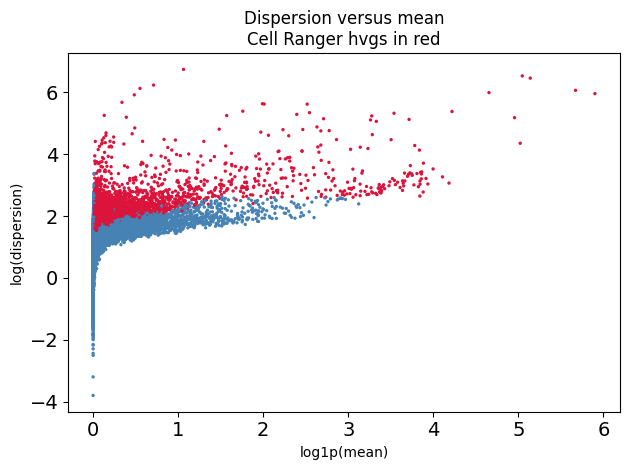

In [30]:
# This code computes HVGs, if they are not already annotated. Other methods are also possible

# This is inverse function to get original adata.layers['X'], if necessary
adata.layers['X'] = 10.0**(adata.layers['logX'] + np.log10(0.1)) - 0.1
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', batch_key='sample', n_bins=20, max_mean=np.inf, layer='X')
boolean_to_color = {True:'crimson',False:'steelblue'}
colors_cell_ranger = [boolean_to_color[True] if x >0 else boolean_to_color[False]
                      for x in adata.var['highly_variable']]
plt.scatter(np.log1p(adata.var['means']), np.log(adata.var['dispersions']),
            s=2, c=colors_cell_ranger)
plt.xlabel('log1p(mean)')
plt.ylabel('log(dispersion)')
plt.title('Dispersion versus mean\nCell Ranger hvgs in red')
print(f'Found {sum(adata.var["highly_variable"])} highly variable genes')
fn = output_dir + '/hvgs_scanpy_cellranger_20bins_nomax.png'
plt.tight_layout()
plt.savefig(fn, dpi=400)
plt.show()
plt.close()

In [31]:
keepGenes = list(adata.var.loc[adata.var['highly_variable']].index)
len(keepGenes)

4437

In [32]:
targets = list(set(interactions['receptor']).union(set(interactions['ligand'])))

In [33]:
# a few ligands/receptors may not be highly variable but we need to keep them as well
print(f'Keeping {len(keepGenes)} HVGs as well as {len(set(targets).difference(set(keepGenes)))} ligands/receptors that are not HVGs')
keepGenes = list(set(targets).union(set(keepGenes)))

Keeping 4437 HVGs as well as 355 ligands/receptors that are not HVGs


### Run interaction tests

This is the slowest part of the analysis, this section could take many days, depending on number of receptors/ cell types and size of data set, and the computational resource (# of CPUs and memory available).

The commands will be written to a script, and the script executed outside the notebook using GNU parallel

In [34]:
# split adata by cellType, compute fraction of cells expressing each gene per cell type, and write adata object to file
# do for all cell types (not just receptor) because will use later
all_fracExp = []
adata_cellTypes = {}
for cellType in adata.obs['cell type'].unique():
    adata_cellTypes[cellType] = adata[adata.obs['cell type'] == cellType, keepGenes].copy()
    adata_cellTypes[cellType].var['fracExp'] = np.sum(adata_cellTypes[cellType].layers['logX'] > 0, axis=0)/adata_cellTypes[cellType].shape[0]
    if cellType in receptor_cellTypes:
        all_fracExp += list(adata_cellTypes[cellType].var.loc[interaction_receptors, 'fracExp'])
        adata_cellTypes[cellType].write(f'{tmp_output_dir}/adata_{cellType}_inttest.h5ad')

__Choose cutoff for receptor expression__

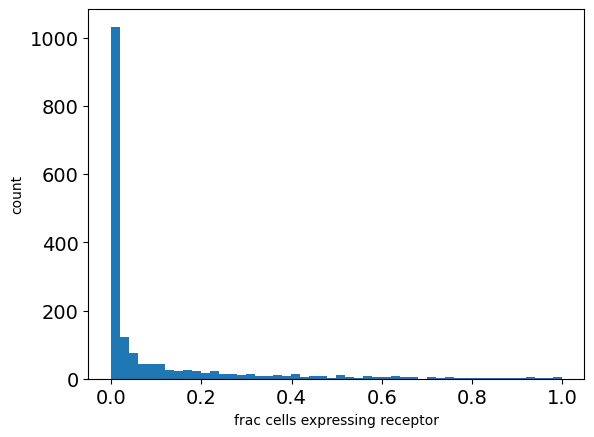

In [35]:
# look at distribution of fraction cells expressing receptors; may use this to choose cutoff for fracExp
plt.hist(all_fracExp, bins=50)
plt.xlabel('frac cells expressing receptor')
plt.ylabel('count')
plt.show()

In [36]:
fracExp_cutoff = 0.05

In [37]:
for cellType in receptor_cellTypes:
    skipping = adata_cellTypes[cellType].var.loc[interaction_receptors,'fracExp'] < fracExp_cutoff
    print(f'{cellType}: Skipping {sum(skipping)} receptors with fracExp < {fracExp_cutoff:0.2f}, {sum(~skipping)} receptors remaining')

PMN_gMDSC: Skipping 359 receptors with fracExp < 0.05, 69 receptors remaining
Macrophages_mMDSC: Skipping 265 receptors with fracExp < 0.05, 163 receptors remaining
T_cells: Skipping 336 receptors with fracExp < 0.05, 92 receptors remaining
Tumor_cells: Skipping 238 receptors with fracExp < 0.05, 190 receptors remaining


In [38]:
interaction_outdir=f'{output_dir}/interaction_test'
!mkdir -p {interaction_outdir}

__Write commands to run.__

Additional covariates can be added to the analysis here in the same way as the ligand analyis 

As in the MAST analysis of ligands, covariates can be added to the command below, by adding any column of anndata's .obs matrix to the `--covariates` option below. They should be comma-delimited, i.e., to add scrublet score, change to `--covariates cngeneson,scrublet`

We had a reviewer suggest doublet score as a covariate, adding this did not hurt but also didn't change results. It does not seem to increase run-time to add covariates, so any covariate that may influence gene expression levels may be sensible to add, any column in adata.obs can be included (though it should have a name withour spaces or strange characters).  Note that if each sample is from a single condition, then sample is not an appropriate covariate, since the it will be impossible to disentangle the condition effect from the sample effect.

#### Generate command file

In [39]:
# This should take a minute or so to run, depending on number of cell types/receptors.
# It checks expression of each receptor in each condition to make sure there is sufficient data

# set force to True to run all tests, otherwise only run genes if output file does not exist
force=False
command_file = open(f'{interaction_outdir}/commands.sh', 'w')
expected_files = set()
num_commands=0
for cellType in receptor_cellTypes:
    curr_adata = adata_cellTypes[cellType]
    keep_receptors = curr_adata.var.loc[interaction_receptors,'fracExp'] >= fracExp_cutoff
    genes = list(keep_receptors.loc[keep_receptors].index)

    outdir=f'{interaction_outdir}/{cellType}'
    !mkdir -p {outdir}
    mast_infile = f'{tmp_output_dir}/adata_{cellType}_inttest.h5ad'
    
    curr_logX = curr_adata.layers['logX']
    fcond1 = np.array(curr_adata.obs['condition'] == condition1)
    fcond2 = np.array(curr_adata.obs['condition'] == condition2)
    for gene in genes:
        output_file = f'{interaction_outdir}/{cellType}/{gene}/interaction_{condition1}_vs_{condition2}.txt'
        
        # check to see if we have data to analyze this gene.
        # we require at least two cells expressing the receptor and two not expressing
        # Additionally, there should be at least one cell expressing and non-expressing for each condition
        geneidx = np.where(curr_adata.var.index == gene)[0]
        fexp = np.array(curr_logX[:,geneidx] > 0).flatten()
        if sum(fexp) < 2:
            continue
        if sum(~fexp) < 2:
            continue
        if (sum(fexp & fcond1) == 0):
            continue
        if (sum(fexp & fcond2)==0):
            continue
        if (sum((~fexp) & fcond1) == 0):
            continue
        if (sum((~fexp) & fcond2) == 0):
            continue
        expected_files.add(output_file)
        if force==False and os.path.exists(output_file):
            continue
        
        cmd=f'mkdir -p {outdir}/{gene} && {Rcommand} --vanilla --args --infile "{mast_infile}" --outdir "{interaction_outdir}/{cellType}"'
        cmd += f' --conditions "{condition1}" "{condition2}"'
        cmd += f' --covariates cngeneson --numcore 1 --genes "{gene}"'
        if force:
            cmd += f' --force'
        cmd += f' < {tutorial_dir}/R/MAST-interactionTest.R &> {outdir}/{gene}/stdout.txt\n'
        command_file.write(cmd)
        num_commands = num_commands+1
command_file.close()
print(f'Wrote command file {interaction_outdir}/commands.sh with {num_commands} commands')

Wrote command file /workdir/tutorial_output/interaction_test/commands.sh with 0 commands


In [40]:
# This is total number of interaction tests we need to run
len(expected_files)

514

__Set the jobs running, using parallel command__

In this cell below, `-j 10` specifies the number of simultaneous jobs to run. Each job uses a single core (as indicated by the --numcore 1 option used above; the MAST run can be parallelized, but most efficient is to run each job on a single core, and run many jobs simultaneously).

I recommend first executing the following cell with '-j 1' (one job only) and then using 'top' in a terminal to determine how much memory the job uses. Then, depending on how many cores and how much memory is available on your machine, you can kill the job (using code below, under the comment HERE IS CODE TO KILL ALL JOBS). Then restart with a number of jobs that your machine can handle.

For example, if one job takes 10 Gb of memory, and your machine has 256 Gb memory available, you should be able to use -j 25, or maybe -j 24 to leave some wiggle room. However, if your machine only has 10 cores, then you will need to use -j 10.

Note that the amount of memory required is proportional to both the number of cells in the data set, and the number of genes being analyzed. So if there are multiple cell types in receptor_cellTypes (each with a different number of cells), you should test the memory usage on a job from the biggest cell type. Or, you can split the jobs up by cell type, and use different levels of parallelization depending on the memory requirements for each.

In [41]:
ct.run_in_background(f'parallel -j 10 < {interaction_outdir}/commands.sh', 
                     stdoutfile=f'{interaction_outdir}/commands_stdout.txt')

calling bash -c 'parallel -j 10 < /workdir/tutorial_output/interaction_test/commands.sh' > /workdir/tutorial_output/interaction_test/commands_stdout.txt 2>&1 &



Once jobs have started, you can use the command below to check how many have finished.

In [42]:
# check progress of jobs.
numdone=0
for f in expected_files:
    if os.path.exists(f):
        numdone=numdone+1
print(f'Done {numdone} out of {len(expected_files)} interaction tests')

Done 514 out of 514 interaction tests


It is recommend to run 'top' on the server to see how memory and CPU usage is doing.

If you are overrunning resources, some jobs may crash and need to be restarted, or you may need to kill all processes (using the code block below). If your jobs don't all finish on the first pass, you can go back up to the 'Generate command file' cell above, make sure to set `force=False`, and it will generate a new commands file containing only the jobs that haven't completed yet. You can then repeat this process until all jobs have finished.

In [43]:
# HERE IS CODE TO KILL ALL JOBS, in case you are overrunning memory or something
# (Note this will kill any R job or parallel command running, but only within the docker container)
subprocess.run(["killall", "parallel"])
subprocess.run(["killall", "/usr/local/lib/R/bin/exec/R"])

/usr/local/lib/R/bin/exec/R: no process found


CompletedProcess(args=['killall', '/usr/local/lib/R/bin/exec/R'], returncode=1)

__When all jobs finished, you may clean up temporary adata files__

In [44]:
for cellType in receptor_cellTypes:
    mast_infile = f'{tmp_output_dir}/adata_{cellType}_inttest.h5ad'
    print(f'Deleting {mast_infile}')
    os.system('rm -f {mast_infile}')

Deleting /workdir/tutorial_output/tmp/NOBACKUP/adata_PMN_gMDSC_inttest.h5ad
Deleting /workdir/tutorial_output/tmp/NOBACKUP/adata_Macrophages_mMDSC_inttest.h5ad
Deleting /workdir/tutorial_output/tmp/NOBACKUP/adata_T_cells_inttest.h5ad
Deleting /workdir/tutorial_output/tmp/NOBACKUP/adata_Tumor_cells_inttest.h5ad


## Read in interaction test results

Need to wait for all interaction tests to finish before coming to this section

In [45]:
inttest = f'interaction_{condition1}_vs_{condition2}'

In [46]:
# the function is I/O intensive so you may not want to use too many cores
ncore=20
deg = ct.read_all_contactTracing_results(receptor_cellTypes, interaction_receptors, interaction_outdir, 
                                         cond1=condition1, cond2=condition2,
                                         inttest=inttest, ncore=ncore, genes=keepGenes)
deg

Done reading files, 517 found of 1712 combinations. concatenating.
Done


AnnData object with n_obs × n_vars = 517 × 4792
    obs: 'cell type', 'receptor'
    layers: 'coef_highCIN_cluster', 'coef_lowCIN', 'coef_cluster', 'pval', 'fdr.i1'

The 'deg' object is an AnnData structure, where each row is a cell_type/receptor combination, 
there is a column for each gene tested for transcriptional response. The layers returned are:
- coef_highCIN_cluster: the logFC applied to cells in the highCIN/receptor_on category. This is the 'interaction_coefficient'
- coef_lowCIN: the logFC applied to cells in the lowCIN categories (receptor on or off)
- coef_cluster: the logFC applied to cells in the receptor_on category (both conditions)
- pval: The p-value describing the significance of the interaction coefficient
- fdr.i1: FDR-corrected p-value. FDR correction is done independently across each row.

In [47]:
deg

AnnData object with n_obs × n_vars = 517 × 4792
    obs: 'cell type', 'receptor'
    layers: 'coef_highCIN_cluster', 'coef_lowCIN', 'coef_cluster', 'pval', 'fdr.i1'

In [48]:
# compute number of significant interactions for each row
deg.obs['numSigI1_fdr05'] = np.sum(deg.layers['fdr.i1'] < 0.05, axis=1)

In [49]:
deg.obs

,cell type,receptor,numSigI1_fdr05
0,PMN_gMDSC,Igf1r,1
1,PMN_gMDSC,Il4ra,0
2,PMN_gMDSC,Tlr2,0
3,PMN_gMDSC,Il13ra1,0
4,PMN_gMDSC,Ccr1,1
...,...,...,...
512,Tumor_cells,H2-T23,127
513,Tumor_cells,Rps19,0
514,Tumor_cells,Lilrb4-mean,2
515,Tumor_cells,Thbs1,26


## Generate a ranked list of interactions

This is one possibly way to rank interactions - of all the interactions with a differentially expressed ligand, rank by size of interaction effect (numSigI1_fdr05)

In [50]:
ligands = ligandsDE[['gene', 'cell type', 'log2FC', 'fdr']].rename(columns={'gene':'ligand',
                                                                           'cell type':'cell_type_ligand'})

In [51]:
# some ligands have log2FC=NA but they are not significant (check)
ligands.loc[pd.isna(ligands['log2FC']),'fdr'].unique()

array([1.])

In [52]:
# they all have FDR of 1 so just set log2FC to 0
ligands.loc[pd.isna(ligands['log2FC']),'log2FC'] = 0

In [53]:
ligands['ligandDE'] = ligands['fdr'] < 0.05

In [54]:
receptors = deg.obs.rename(columns={'cell type':'cell_type_receptor'})

In [55]:
ranked_interactions = interactions.merge(ligands, on='ligand').merge(receptors, on='receptor').sort_values(
    by=['ligandDE', 'numSigI1_fdr05'], ascending=False)[['ligand', 'cell_type_ligand', 'receptor', 'cell_type_receptor',
                                                         'log2FC', 'fdr', 'ligandDE', 'numSigI1_fdr05']].rename(
    columns={'log2FC':'log2FC_ligand', 'fdr':'fdr_ligand', 'numSigI1_fdr05':'numSigI1_fdr05_receptor'})
ranked_interactions.to_csv(f'{output_dir}/ranked_interactions.txt', index=False, sep='\t')
print(f'Wrote ranked interaction list to {output_dir}/ranked_interactions.txt')

Wrote ranked interaction list to /workdir/tutorial_output/ranked_interactions.txt


In [56]:
# Here are top 5
ranked_interactions.iloc[:5]

,ligand,cell_type_ligand,receptor,cell_type_receptor,log2FC_ligand,fdr_ligand,ligandDE,numSigI1_fdr05_receptor
15976,Ptprc,PMN_gMDSC,Mrc1,Macrophages_mMDSC,0.078864,1.768921e-11,True,403
1669,Il4,PMN_gMDSC,Tlr2,Macrophages_mMDSC,-0.393897,4.157179e-02,True,323
1705,Hsp90b1,PMN_gMDSC,Tlr2,Macrophages_mMDSC,-0.188483,4.319675e-17,True,323
1708,Hsp90b1,T_cells,Tlr2,Macrophages_mMDSC,-0.119850,3.225157e-05,True,323
1732,Hras,Macrophages_mMDSC,Tlr2,Macrophages_mMDSC,0.040937,5.657769e-05,True,323


In [57]:
deg.shape

(517, 4792)

You can also make a list of ranked interactions integrated over ligand cell type, for example, require ligand DE in one cell type

Here, the values of ligand cell type, log2FC, and fdr are all for the ligand cell type with minimum fdr value

In [58]:
ranked_interactions2 = ranked_interactions.loc[ranked_interactions.drop(columns='cell_type_ligand').groupby(
    ['ligand', 'receptor', 'cell_type_receptor']).idxmin()['fdr_ligand']].sort_values(
    by=['ligandDE', 'numSigI1_fdr05_receptor'], ascending=False)
ranked_interactions2.to_csv(f'{output_dir}/ranked_interactions_across_ligand_cell_type.txt', index=False, sep='\t')
print('Wrote ranked interaction list (integrated over ligand cell type) to {output_dir}/ranked_interactions_across_ligand_cell_type.txt')

Wrote ranked interaction list (integrated over ligand cell type) to {output_dir}/ranked_interactions_across_ligand_cell_type.txt


In [59]:
ranked_interactions2.iloc[:5]

,ligand,cell_type_ligand,receptor,cell_type_receptor,log2FC_ligand,fdr_ligand,ligandDE,numSigI1_fdr05_receptor
15976,Ptprc,PMN_gMDSC,Mrc1,Macrophages_mMDSC,0.078864,1.768921e-11,True,403
1774,Bgn,Tumor_cells,Tlr2,Macrophages_mMDSC,0.010986,9.320374e-03,True,323
1813,Cd14,PMN_gMDSC,Tlr2,Macrophages_mMDSC,0.039223,5.820054e-09,True,323
1846,Hmgb1,Tumor_cells,Tlr2,Macrophages_mMDSC,-0.131984,1.375255e-07,True,323
1732,Hras,Macrophages_mMDSC,Tlr2,Macrophages_mMDSC,0.040937,5.657769e-05,True,323


## Explore downstream interaction effects

We can use the coef estimates in the deg structure, along with p-values, to explore downstream effects.

### Optional: fix NA coefficients

A substantial number of logFC estimates coming from MAST are recorded as NA, even when the p-value is significant. I believe this is because the MAST estimate is hitting +/- infinity, or passing some internal boundaries set by MAST. In this section we can replace the NAs with a rough estimate based on mean # of expressed cells in different categories.

__First, how many of these NAs are there?__

In [60]:
sig = deg.layers['fdr.i1'] < 1
print(f'Out of {sum(sum(sig))} tests with fdr < 1:')
coef_layers = [x for x in deg.layers.keys() if x.startswith('coef') and not x.endswith('_est')] 
for layer in coef_layers:
    na = np.isnan(deg.layers[layer])
    print(f'  {sum(sum(na & sig))} ({sum(sum(na & sig))/sum(sum(sig))*100:0.2f}%) have {layer}=NA')

Out of 339463 tests with fdr < 1:
  32500 (9.57%) have coef_highCIN_cluster=NA
  4487 (1.32%) have coef_lowCIN=NA
  6564 (1.93%) have coef_cluster=NA


In [61]:
# Here is code that creates the estimates - for each coefficient in deg.layers, it addes another layer with the suffix _est that gives
# the rough estimated values

# Note- it will distribute each row of deg across the cores specified by ncores, in chunks of size chunksize.
# I have found it is much faster to use big chunks.
ct.estimate_contactTracing_coefs(deg, adata, condition1, condition2, ncores=10, chunksize=50)

Done 53 out of 517 (10.3%)
Done 105 out of 517 (20.3%)
Done 157 out of 517 (30.4%)
Done 209 out of 517 (40.4%)
Done 261 out of 517 (50.5%)
Done 313 out of 517 (60.5%)
Done 365 out of 517 (70.6%)
Done 417 out of 517 (80.7%)
Done 469 out of 517 (90.7%)


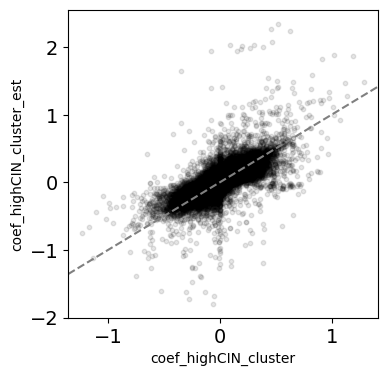

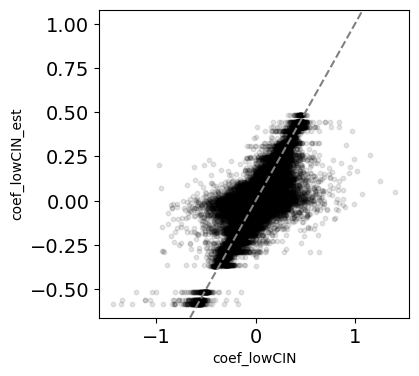

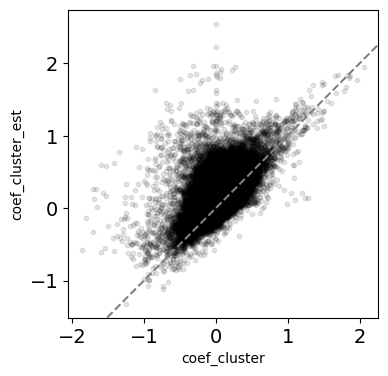

In [62]:
# plot MAST estimates vs rough estimates - they should fall along the diagonal, with a good deal of noise.
# (MAST model is much more sophisticated).
#log_factor = np.log10(2)
for layer in coef_layers:
    if f'{layer}_est' in deg.layers:
        plt.subplots(figsize=(4,4))
        plt.scatter(np.array(deg.layers[layer]).reshape(-1), 
                    np.array(deg.layers[f'{layer}_est']).reshape(-1), color='black', s=10, alpha=0.1)
        plt.gca().axline((1,1), slope=1, ls='--', color='gray')
        plt.xlabel(layer)
        plt.ylabel(f'{layer}_est')
        plt.show()

__If you want to replace NAs with estimated values, do:__

In [63]:
for layer in coef_layers:
    f = np.isnan(deg.layers[layer])
    deg.layers[layer][f] = deg.layers[f'{layer}_est'][f]

In [64]:
# confirm there are no more NAs
sig = deg.layers['fdr.i1'] < 1
print(f'Out of {sum(sum(sig))} tests with fdr < 1:')
for layer in coef_layers:
    na = np.isnan(deg.layers[layer])
    print(f'  {sum(sum(na & sig))} ({sum(sum(na & sig))/sum(sum(sig))*100:0.2f}%) have {layer}=NA')

Out of 339463 tests with fdr < 1:
  0 (0.00%) have coef_highCIN_cluster=NA
  0 (0.00%) have coef_lowCIN=NA
  0 (0.00%) have coef_cluster=NA


### Example plot showing interaction effect for single receptor in one cell type


The plot shows the log-fold coefficient for genes when the receptors is on, in each of the two conditions.

The color of the dot shows the size of the 'interaction effect'. The size of the dot shows the significance (-log10 pvalue).

Points falling along the diagonal show the same effect in both conditions, as you move away from the diagonal you can see genes that are affected differently.

Text(0.5, 1.0, 'Macrophages_mMDSC Mrc1')

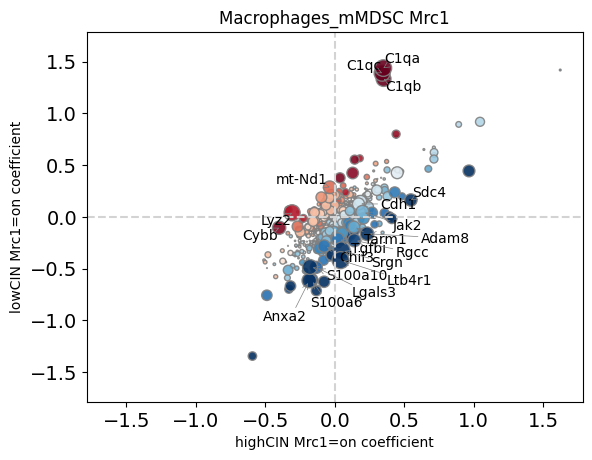

In [65]:
cellType = 'Macrophages_mMDSC'
gene = 'Mrc1'
numLabel=20

#cellType='PMN_gMDSC'
#gene='Cd74'

idx = np.where((deg.obs['cell type'] == cellType) & (deg.obs['receptor'] == gene))[0][0]

pvals = deg.layers['pval'][idx,:].reshape(-1)
cond1On = (deg.layers[f'coef_{condition1}_cluster'][idx,:] + deg.layers['coef_cluster'][idx,:]).reshape(-1)
cond2On = (deg.layers[f'coef_{condition2}'][idx,:] + deg.layers['coef_cluster'][idx,:]).reshape(-1)

# color by interaction effect
cvals = deg.layers[f'coef_{condition1}_cluster'][idx,:].reshape(-1)

# size by p-value
svals = -np.log10(pvals)
# 150 just gives reasonable size dot, can adjust as needed
svals = svals * 150/np.max(svals)


nanvals = (np.isnan(cond1On)) | (np.isnan(cond2On))
f = (pvals < 1) & (~nanvals)
if sum(nanvals) > 0:
    print(f'Skipping {sum(nanvals)} points with NAN coefs and p-val < 1, plotting {sum(f)} genes')

order = np.argsort(svals[f])

plt.scatter(cond2On[f][order], cond1On[f][order], 
            #c=-np.log10(sigvals[f]), cmap=plt.cm.Greys, vmin=0, vmax=20, s=svals[f])
            c=cvals[f][order], s=svals[f][order],
            edgecolors=ct.makeTransparent('gray', alpha=0.5),
            cmap=plt.cm.RdBu_r, vmin=-0.3, vmax=0.3, alpha=0.9)


# add text labels to most significant genes
use_numLabel = numLabel
if use_numLabel > sum(f):
    use_numLabel = sum(f)
tmpdf = pd.DataFrame({'xvals':cond2On[f][order],
                      'yvals':cond1On[f][order],
                      'gene':deg.var.index[f][order],
                      's':svals[f][order]}).sort_values(by='s', ascending=False).reset_index(drop=True)

texts = []
for i in tmpdf.iloc[:use_numLabel].index:
    texts.append(plt.text(tmpdf.loc[i,'xvals'], tmpdf.loc[i,'yvals'], tmpdf.loc[i,'gene'], fontsize=10))
niter = adjust_text(texts, 
                    x=list(tmpdf['xvals']), 
                    y=list(tmpdf['yvals']), 
                    #avoid_self=True, force_text=(2,2),
                    #force_pull=(0.001,0.001),
                    expand_points=(1.1, 1.1),
                    expand_text=(1.1,1.1),
                    arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
                     
plt.xlabel(f'{condition1} {gene}=on coefficient')
plt.ylabel(f'{condition2} {gene}=on coefficient')
maxval = np.max(np.abs(list(cond2On[f])+list(cond1On[f])))*1.1
plt.xlim(-maxval, maxval)
plt.ylim(-maxval, maxval)
linelist=[]
linelist += plt.plot([-maxval, maxval], [0,0], c='lightgray', linestyle='dashed')
linelist += plt.plot([0,0], [-maxval, maxval], c='lightgray', linestyle='dashed')
plt.title(cellType + ' ' + gene)


## Run cluster test on all ligands/receptors and compute differential components

This is done in preparation of making the circos plot, we use diffusion components to create an ordering of ligands/receptors around the circle

In the CIN/TME paper, this was the 'cluster' test, run in MAST. But it is very slow to do in MAST and only used for visualization so it makes more sense to use a faster algorithm. Using scanpy here. It still takes awhile, but hopefully minutes to an hour or so, rather than days.

In [66]:
adata

AnnData object with n_obs × n_vars = 33092 × 16685
    obs: 'totReads', 'doublet_score', 'library_size', 'sample', 'condition', 'batch', 'cell type', 'cngeneson'
    var: 'gene_ids', 'genome', 'highly_variable', 'humanGene', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell type_colormap', 'cell type_colors', 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'X', 'X_impute', 'logX'
    obsp: 'connectivities', 'distances'

In [67]:
cellTypes = adata.obs['cell type'].unique()
cellTypes

['NK_cells', 'Macrophages_mMDSC', 'Osteoclasts', 'Tumor_cells', 'PMN_gMDSC', ..., 'B_cells', 'Fibroblast_cells', 'pDC', 'Endothelial_cells', 'Mast_cells']
Length: 12
Categories (12, object): ['B_cells', 'Endothelial_cells', 'Fibroblast_cells', 'Macrophages_mMDSC', ..., 'T_cells', 'Tumor_cells', 'cDC', 'pDC']

In [68]:
sig_receptors = deg.obs.loc[deg.obs['numSigI1_fdr05'] > 0]
sig_receptors.shape

(340, 3)

In [69]:
# Create object to hold differential expression results
# It is an anndata structure with rows for every target gene and cell type we are interested in
# and columns for every gene

# The targets we are interested in are receptors with some minimum number of interaction effects,
# and ligands associated with these receptors.

minInteractions=1

receptor_df = deg.obs.loc[deg.obs['numSigI1_fdr05'] >= minInteractions][['cell type', 'receptor']].rename(columns={'receptor':'target'})
ligand_df = pd.DataFrame(product(ligand_cellTypes, 
                                 interactions.loc[interactions['receptor'].isin(receptor_df['target']), 'ligand']),
                         columns=['cell type', 'target'])
targets_df = pd.concat([receptor_df, ligand_df])
targets_df = targets_df[~targets_df.duplicated()].sort_values(by=['cell type', 'target']).reset_index(drop=True)
targets_df.index = targets_df.index.map(str)
diffComp = sc.AnnData(X=np.empty(shape=(targets_df.shape[0], deg.var.shape[0]), dtype=np.float32),
                      obs=targets_df, var=deg.var)
diffComp

AnnData object with n_obs × n_vars = 3187 × 4792
    obs: 'cell type', 'target'

In [70]:
# add layers for all the DE statistics
diffComp.layers['pval'] = diffComp.X.copy()
diffComp.layers['fdr'] = diffComp.X.copy()
diffComp.layers['lfc'] = diffComp.X.copy()
diffComp.layers['score'] = diffComp.X.copy()

In [71]:
def de_score(targetCellType):
    (target, cellType) = targetCellType
    adata = adata_cellTypes[cellType]
    idx = np.where(adata.var.index == target)[0]
    isExpressed = np.reshape(adata.layers['logX'][:,idx] > 0, -1)
    tmpcol = f'{target}_cluster'
    adata.obs[tmpcol] = pd.Categorical(['expressed' if x else 'not' for x in isExpressed], categories=['expressed', 'not'])
    if (sum(adata.obs[tmpcol].value_counts() <=1) > 0):
        # cannot compute if we don't have more than one cell in both categories...skip
        adata.obs.drop(columns=tmpcol, inplace=True)
        return (target, cellType, 0)
    newkey=f'rank_genes_groups_{target}'
    sc.tl.rank_genes_groups(adata, groupby=tmpcol, layer='logX', method='wilcoxon', groups=['expressed'], key_added=newkey)
    adata.obs.drop(columns=tmpcol, inplace=True)
    tmprg = adata.uns[newkey]
    pvals = np.array([x[0] for x in tmprg['pvals']])
    minPval = np.min(pvals[pvals > 0])
    pvals[pvals==0] = minPval
    scores = np.array([x[0] for x in tmprg['scores']])
    fdr = statsmodels.stats.multitest.multipletests(pvals, method='fdr_bh')[1]
    tmpdf = pd.DataFrame({'gene':[x[0] for x in tmprg['names']],
                          'pval':pvals,
                          'fdr':fdr,
                          'lfc':[x[0] for x in tmprg['logfoldchanges']],
                         'score':scores}).set_index('gene')
    tmpdf['score'] =  -np.log10(tmpdf['pval'])*tmpdf['lfc']
    adata.uns.pop(newkey)
    return (target,cellType,tmpdf)
    #return -np.log10(tmpdf['pval'])*tmpdf['lfc']

The following cell loops through all cell types, all ligands/receptors, and performs a test for differential expression across
all genes, for whehter gene expression is related to whether the ligand/receptor is expressed. It is all done
within the given cell type. In the end, `diffComp` is an adta object where:
- each row is a ligand or a receptor in a particular cell type
- each column is a gene (same columns as adata)
- there are matrices .layers['lfc'], .layers['pval'], .layers['fdr'], and .layers['score'] with results from rank_genes_groups function ('wilcoxan' method).

In [72]:
# set this to the number of jobs you want to run simultaneously
num_processes=20
targetlist = [(diffComp.obs.loc[x, 'target'], diffComp.obs.loc[x, 'cell type']) for x in diffComp.obs.index]
numjob=diffComp.shape[0]
numdone=0
fracReport=0.1
nextfrac=0.1
print(f'Running LRT tests for all ligands/receptors')
with multiprocessing.Pool(processes=num_processes) as p:
    func = partial(de_score)
    for tmp in p.imap_unordered(func, targetlist, chunksize=50):
        target = tmp[0]
        cellType=tmp[1]
        idx = np.where((diffComp.obs['target'] == target) & (diffComp.obs['cell type'] == cellType))[0][0]
        if type(tmp[2]) == int:
            diffComp.layers['pval'][idx,:] = 1
            diffComp.layers['fdr'][idx,:] = 1
            diffComp.layers['lfc'][idx,:] = 0
            diffComp.layers['score'][idx,:] = 0
        else:
            for layer in ['pval', 'fdr', 'lfc', 'score']:
                diffComp.layers[layer][idx,:] = np.array(tmp[2].loc[diffComp.var.index, layer]).reshape(-1)
        numdone=numdone+1
        if numdone/numjob > nextfrac:
            print(f'Done {numdone} out of {numjob} LRT tests ({numdone/numjob*100:.1f}% done)')
            nextfrac = nextfrac + fracReport

Running LRT tests for all ligands/receptors
Done 319 out of 3187 LRT tests (10.0% done)
Done 638 out of 3187 LRT tests (20.0% done)
Done 957 out of 3187 LRT tests (30.0% done)
Done 1275 out of 3187 LRT tests (40.0% done)
Done 1594 out of 3187 LRT tests (50.0% done)
Done 1913 out of 3187 LRT tests (60.0% done)
Done 2231 out of 3187 LRT tests (70.0% done)
Done 2550 out of 3187 LRT tests (80.0% done)
Done 2869 out of 3187 LRT tests (90.0% done)
Done 3187 out of 3187 LRT tests (100.0% done)


In [73]:
diffComp.obs['fracExp'] = -1
for i in diffComp.obs.index:
    target = diffComp.obs.loc[i,'target']
    cellType = diffComp.obs.loc[i,'cell type']
    diffComp.obs.loc[i,'fracExp'] = adata_cellTypes[cellType].var.loc[target,'fracExp']

In [74]:
# set score to zero when testing gene for transcriptional response to itself
idx1=0
count=0
for i in diffComp.obs.index:
    target = diffComp.obs.loc[i,'target']
    cellType = diffComp.obs.loc[i,'cell type']
    if target in diffComp.var.index:
        idx2 = np.where(diffComp.var.index == target)[0][0]
        diffComp.layers['score'][idx1,idx2] = 0
        count=count+1
    idx1=idx1+1
print(f'Fixed {count} scores for DE of own gene to zero')

Fixed 3187 scores for DE of own gene to zero


In [75]:
# This took awhile to compute, so save:
diffComp.write(f'{output_dir}/diffComp.h5ad')

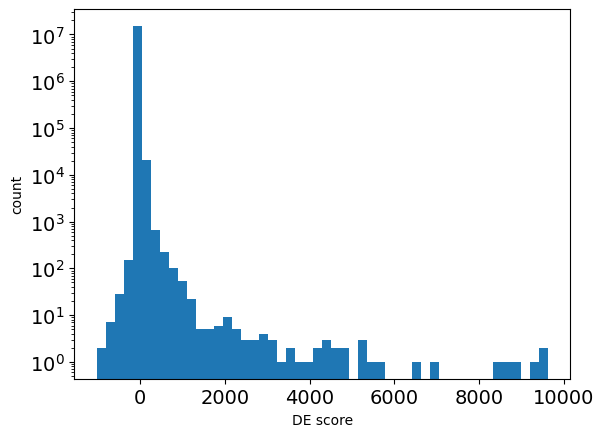

In [76]:
plt.hist(diffComp.layers['score'].reshape(-1), bins=50)
plt.xlabel('DE score')
plt.ylabel('count')
plt.yscale('log')
plt.show()

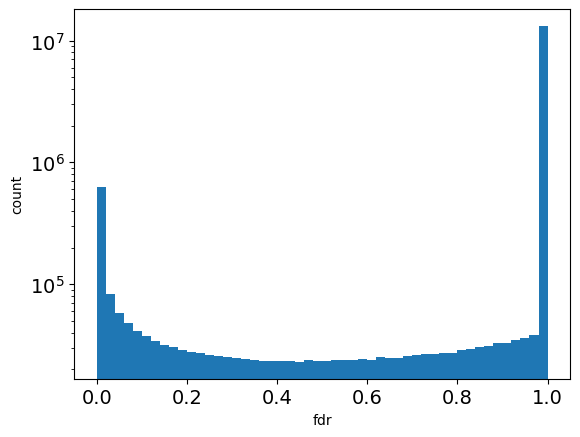

In [77]:
plt.hist(diffComp.layers['fdr'].reshape(-1), bins=50)
plt.xlabel('fdr')
plt.ylabel('count')
plt.yscale('log')
plt.show()

In [78]:
diffComp.layers['score-sig'] = diffComp.layers['score'].copy()
f = diffComp.layers['fdr'] > 0.05
diffComp.layers['score-sig'][f]= 0

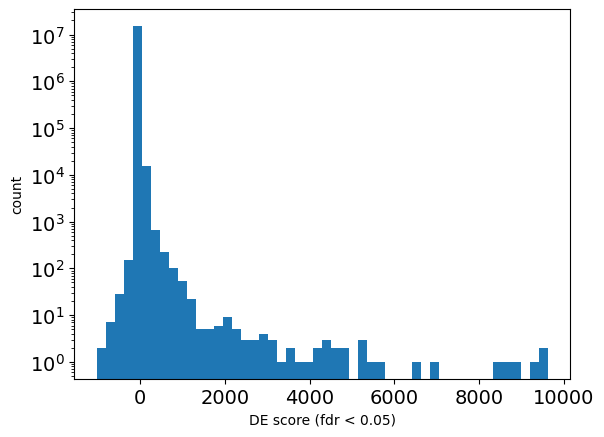

In [79]:
plt.hist(diffComp.layers['score-sig'].reshape(-1), bins=50)
plt.xlabel('DE score (fdr < 0.05)')
plt.ylabel('count')
plt.yscale('log')
plt.show()

### Compute diffusion maps

In [80]:
diffComp

AnnData object with n_obs × n_vars = 3187 × 4792
    obs: 'cell type', 'target', 'fracExp'
    layers: 'pval', 'fdr', 'lfc', 'score', 'score-sig'

In [81]:
diffComp.X = diffComp.layers['score']

In [82]:
cellTypes=diffComp.obs['cell type'].value_counts().index
sc.settings.verbosity = 0
diffComp.obs['cell_type_dc1'] = 0
diffComp.obs['cell_type_dc2'] = 0
!mkdir -p {output_dir}/diffusionComponents
for cellType in cellTypes:
    f = diffComp.obs['cell type'] == cellType
    tmp = diffComp[f].copy()
    print(cellType,tmp.shape)
    if(tmp.shape[0] < 5):
        print(f'Skipping {cellType}, only {tmp.shape[0]} rows')
        continue
    init_npcs = np.min([50, tmp.shape[0]-2])
    sc.pp.pca(tmp, n_comps=init_npcs)
    if np.min(tmp.uns['pca']['variance'])==0:
        init_npcs = np.argmin(tmp.uns['pca']['variance'])
        tmp.uns['pca']['variance'] = tmp.uns['pca']['variance'][:init_npcs]
        tmp.uns['pca']['variance_ratio'] = tmp.uns['pca']['variance_ratio'][:init_npcs]
    #sc.pl.pca_variance_ratio(tmp, n_pcs=init_npcs, log=True)
    x = [x for x in range(len(tmp.uns['pca']['variance_ratio']))]
    y = np.log(tmp.uns['pca']['variance_ratio'])
    knee = KneeLocator(x=x, y=y, curve='convex', direction='decreasing', online=True, interp_method='polynomial')
    #knee.plot_knee_normalized()

    opt_n_pcs = knee.knee+1
    print('Optimal Number of PCs: ', str(opt_n_pcs))
    sc.pp.pca(tmp, n_comps=opt_n_pcs)
    #dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(tmp.obsm['X_pca']), n_components=15)
    #ms_data = palantir.utils.determine_multiscale_space(dm_res, n_eigs=15)
    dm_res = palantirFuncs.run_diffusion_maps(pd.DataFrame(tmp.obsm['X_pca']), n_components=15)
    ms_data = palantirFuncs.determine_multiscale_space(dm_res, n_eigs=15)
    tmp.obsm['DC'] = ms_data.to_numpy()
    diffComp.obs.loc[f,'cell_type_dc1'] = tmp.obsm['DC'][:,0]
    diffComp.obs.loc[f,'cell_type_dc2'] = tmp.obsm['DC'][:,1]
    
    # get a version normalized by cell type for circos plots
    maxval = np.max(np.abs(tmp.obsm['DC'][:,0]))
    if maxval == 0:
        maxval = 1
    diffComp.obs.loc[f,'cell_type_dc1_norm'] = tmp.obsm['DC'][:,0]/maxval

Tumor_cells (353, 4792)
Optimal Number of PCs:  22
Determing nearest neighbor graph...


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Macrophages_mMDSC (334, 4792)
Optimal Number of PCs:  20
Determing nearest neighbor graph...
T_cells (275, 4792)
Optimal Number of PCs:  14
Determing nearest neighbor graph...
PMN_gMDSC (265, 4792)
Optimal Number of PCs:  14
Determing nearest neighbor graph...
B_cells (245, 4792)
Optimal Number of PCs:  10
Determing nearest neighbor graph...
Endothelial_cells (245, 4792)
Optimal Number of PCs:  7
Determing nearest neighbor graph...
Fibroblast_cells (245, 4792)
Optimal Number of PCs:  21
Determing nearest neighbor graph...
Mast_cells (245, 4792)
Optimal Number of PCs:  19
Determing nearest neighbor graph...
NK_cells (245, 4792)
Optimal Number of PCs:  10
Determing nearest neighbor graph...
Osteoclasts (245, 4792)
Optimal Number of PCs:  7
Determing nearest neighbor graph...
cDC (245, 4792)
Optimal Number of PCs:  11
Determing nearest neighbor graph...
pDC (245, 4792)
Optimal Number of PCs:  7
Determing nearest neighbor graph...


__DC plots__

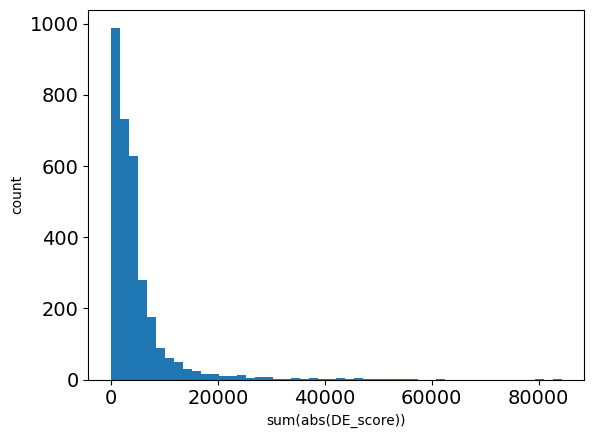

In [83]:
# size each receptor/ligand by sum of abs(DE scores) across all genes
diffComp.obs['absDE'] = np.sum(np.abs(diffComp.layers['score']), axis=1)
plt.hist(diffComp.obs['absDE'], bins=50)
plt.xlabel('sum(abs(DE_score))')
plt.ylabel('count')
diffComp.obs['absDE_scaled'] = diffComp.obs['absDE']/np.max(diffComp.obs['absDE'])

Tumor_cells (353, 4792)


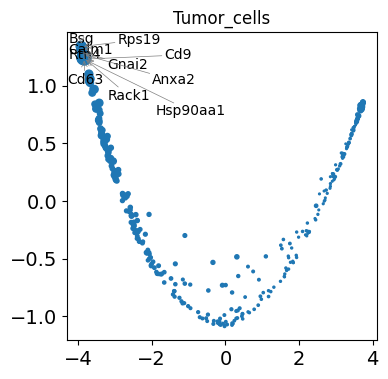

Macrophages_mMDSC (334, 4792)


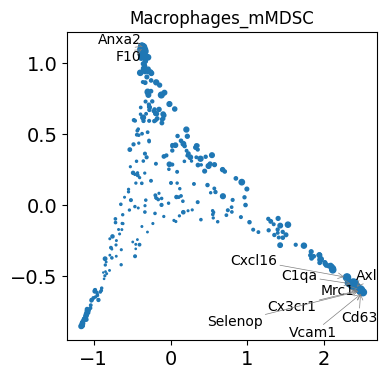

T_cells (275, 4792)


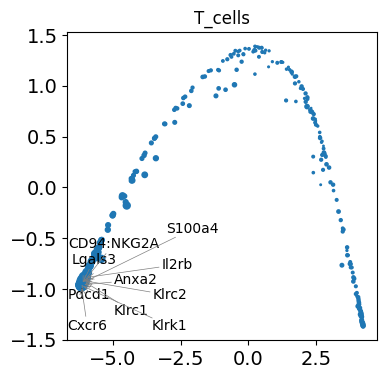

PMN_gMDSC (265, 4792)


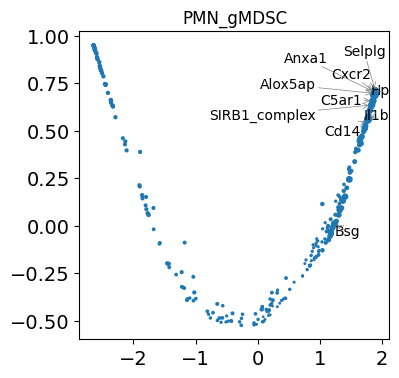

B_cells (245, 4792)


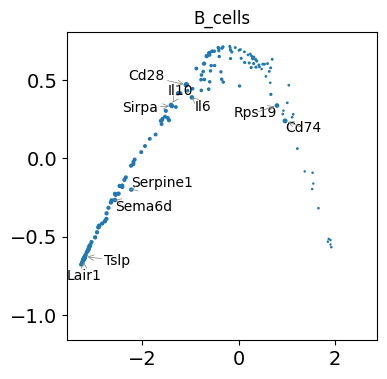

Endothelial_cells (245, 4792)


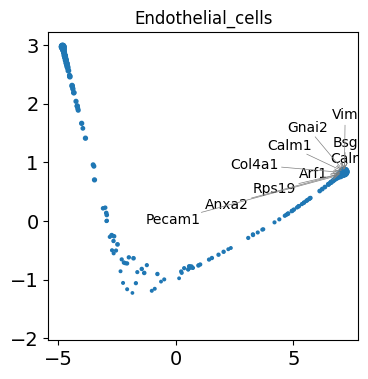

Fibroblast_cells (245, 4792)


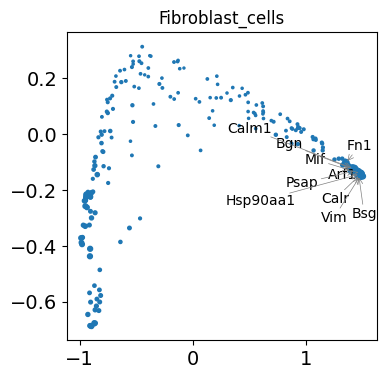

Mast_cells (245, 4792)


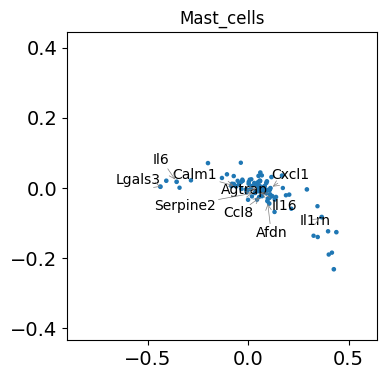

NK_cells (245, 4792)


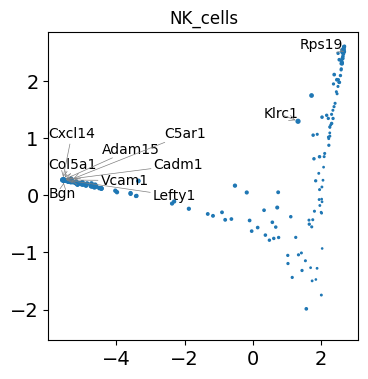

Osteoclasts (245, 4792)


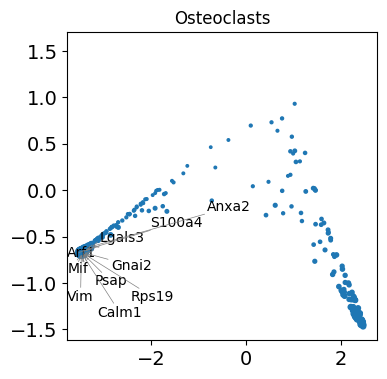

cDC (245, 4792)


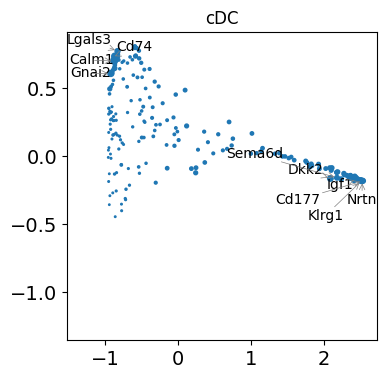

pDC (245, 4792)


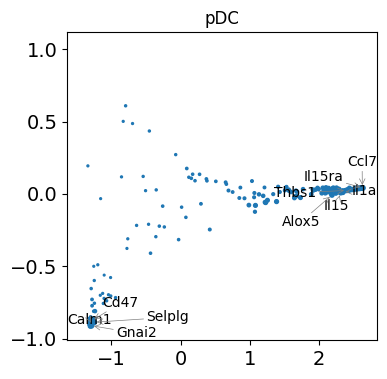

In [84]:
sc.settings.verbosity = 0
numLabel=10
sizeFactor=100  # adjust to scale poinst
for cellType in cellTypes:
    f = diffComp.obs['cell type'] == cellType
    tmp = diffComp[f].copy()
    print(cellType,tmp.shape)
    if(tmp.shape[0] < numLabel):
        continue
    plt.subplots(figsize=(4,4))
    
    xvals = np.array(tmp.obs['cell_type_dc1'])
    yvals = np.array(tmp.obs['cell_type_dc2'])
    sizevals = np.array(tmp.obs['absDE_scaled']*sizeFactor)
    labels = np.array(tmp.obs['target'])
    plt.scatter(xvals, yvals, s=sizevals)
    plt.title(cellType)
    
    texts = []
    tmpobs = tmp.obs.sort_values(by='absDE_scaled', ascending=False).iloc[:numLabel]
    for i in tmpobs.index:
        texts.append(plt.text(tmpobs.loc[i,'cell_type_dc1'], tmpobs.loc[i,'cell_type_dc2'], tmpobs.loc[i,'target'],
                             fontsize=10))
    f = list(range(0, len(x), 50))
    niter = adjust_text(texts, 
                        x=xvals, y=yvals, 
                        #avoid_self=True, force_text=(2,2),
                        #force_pull=(0.001,0.001),
                        expand_points=(0.1,0.1),
                        expand_text=(1.1,1.1),
                        arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
                     
    
    plt.savefig(f'{output_dir}/diffusionComponents/diffusion_components_{cellType}.png', dpi=300, bbox_inches='tight')
    plt.show()

### GSEA analysis of DCs

GSEA analysis may yield some insight about biological processes underlying the diffusion components.

A GMT file is required, they may be specialized for each cell type, the ones we use are in the tutorial data directory.

__First, for each gene and each cell type, compute the correlation between DC1 and the DE Scores,
we will use this correlation as a score to feed GSEA__

In [85]:
for cellType in diffComp.obs['cell type'].unique():
    f = (diffComp.obs['cell type'] == cellType)
    print(cellType, sum(f), sum(diffComp.obs['cell type'] == cellType))
    dc = diffComp.obs.loc[f,'cell_type_dc1']
    corrCol = f'{cellType}_dc1_corr'
    for g in diffComp.var.index:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            diffComp.var.loc[g,corrCol] = np.corrcoef(dc.to_numpy(), diffComp[f,g].X.flatten())[0,1]

B_cells 245 245
Endothelial_cells 245 245
Fibroblast_cells 245 245
Macrophages_mMDSC 334 334
Mast_cells 245 245
NK_cells 245 245
Osteoclasts 245 245
PMN_gMDSC 265 265
T_cells 275 275
Tumor_cells 353 353
cDC 245 245
pDC 245 245


__Also, in our case, the data is from mouse but GMT files use human genes. We need a mapping from mouse to human gene names.__

Our GSEA code will use this mapping, plus the capitalized version of any mouse gene that does not appear in this mapping, if the capitalized version appears in the human gene set.

In [86]:
tmp = pd.read_csv(f'{tutorial_dir}/data/mouse_to_human_genes.txt', sep='\t')
tmp.iloc[:5]

,mouseGene,humanGene
0,Sox17,SOX17
1,Mrpl15,MRPL15
2,Lypla1,LYPLA1
3,Tcea1,TCEA1
4,Rgs20,RGS20


In [87]:
mToH_mapping = {}
for i in tmp.index:
    mToH_mapping[tmp.loc[i,'mouseGene']] = tmp.loc[i,'humanGene']

In [88]:
# This runs GSEA in each cell type and loads the results
# Each cell type should take a minute or so
dc1_gsea_results = []
for cellType in diffComp.obs['cell type'].unique():
    gmtfile = f'{tutorial_dir}/data/GSEA/{cellType}.gmt'
    if os.path.exists(gmtfile):
        print(f'Using {gmtfile} for {cellType}')
    else:
        gmtfile=f'{tutorial_dir}/data/GSEA/All_Immune_Signatures.gmt'
        print(f'No GMT file found for {cellType}... using default file {gmtfile}')
    if not os.path.exists(gmtfile):
        print(f'{gmtfile} not found')
        break
    gmtMeta = pd.read_csv(gmtfile, index_col=None, usecols=[0,1], header=None, delimiter='\t')
    gmtMeta.columns = ['name','desc']
    gmtMeta['name'] = gmtMeta['name'].str.strip().str.upper()
    gmtMeta.loc[gmtMeta['desc'].str.match('^>'),1]=''
    compName=f'{cellType}_dc1'
    output_root=f'{outdir}/{cellType}'
    stat = f'{cellType}_dc1_corr'
    scores = diffComp.var[stat].copy()
    scores = scores.loc[scores != 0]
    scores = scores.loc[~np.isnan(scores)]
    if (scores.shape[0] < 2):
        continue
    scores.sort_values(ascending=False, inplace=True)
    rank = ct.gsea_linear_scale(scores)
    currResults = ct.run_gsea(rank, output_root, gmtfile=gmtfile, force=False, wait=True, label=compName, readonly=False,
                             gene_map=mToH_mapping)
    currResults['cell type'] = cellType
    currResults = currResults.merge(gmtMeta, on='name')
    currResults['name'] = currResults['name'] + ' ' + currResults['desc']
    dc1_gsea_results.append(currResults)
dc1_gsea_results = pd.concat(dc1_gsea_results).reset_index(drop=True)

Using /workdir/ContactTracing_tutorial/data/GSEA/B_cells.gmt for B_cells
Dropping 3 results with no human gene mapping
Reading positive GSEA results rom /workdir/tutorial_output/interaction_test/Tumor_cells/B_cells/B_cells_dc1.GseaPreranked.1682625167919/gsea_report_for_na_pos_1682625167919.tsv
Reading negative GSEA results rom /workdir/tutorial_output/interaction_test/Tumor_cells/B_cells/B_cells_dc1.GseaPreranked.1682625167919/gsea_report_for_na_neg_1682625167919.tsv
Using /workdir/ContactTracing_tutorial/data/GSEA/Endothelial_cells.gmt for Endothelial_cells
Dropping 2 results with no human gene mapping
Reading positive GSEA results rom /workdir/tutorial_output/interaction_test/Tumor_cells/Endothelial_cells/Endothelial_cells_dc1.GseaPreranked.1682625203408/gsea_report_for_na_pos_1682625203408.tsv
Reading negative GSEA results rom /workdir/tutorial_output/interaction_test/Tumor_cells/Endothelial_cells/Endothelial_cells_dc1.GseaPreranked.1682625203408/gsea_report_for_na_neg_168262520340

In [89]:
Rcommand

'MKL_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 OMP_NUM_THREADS=1 R'

Macrophages_mMDSC 29


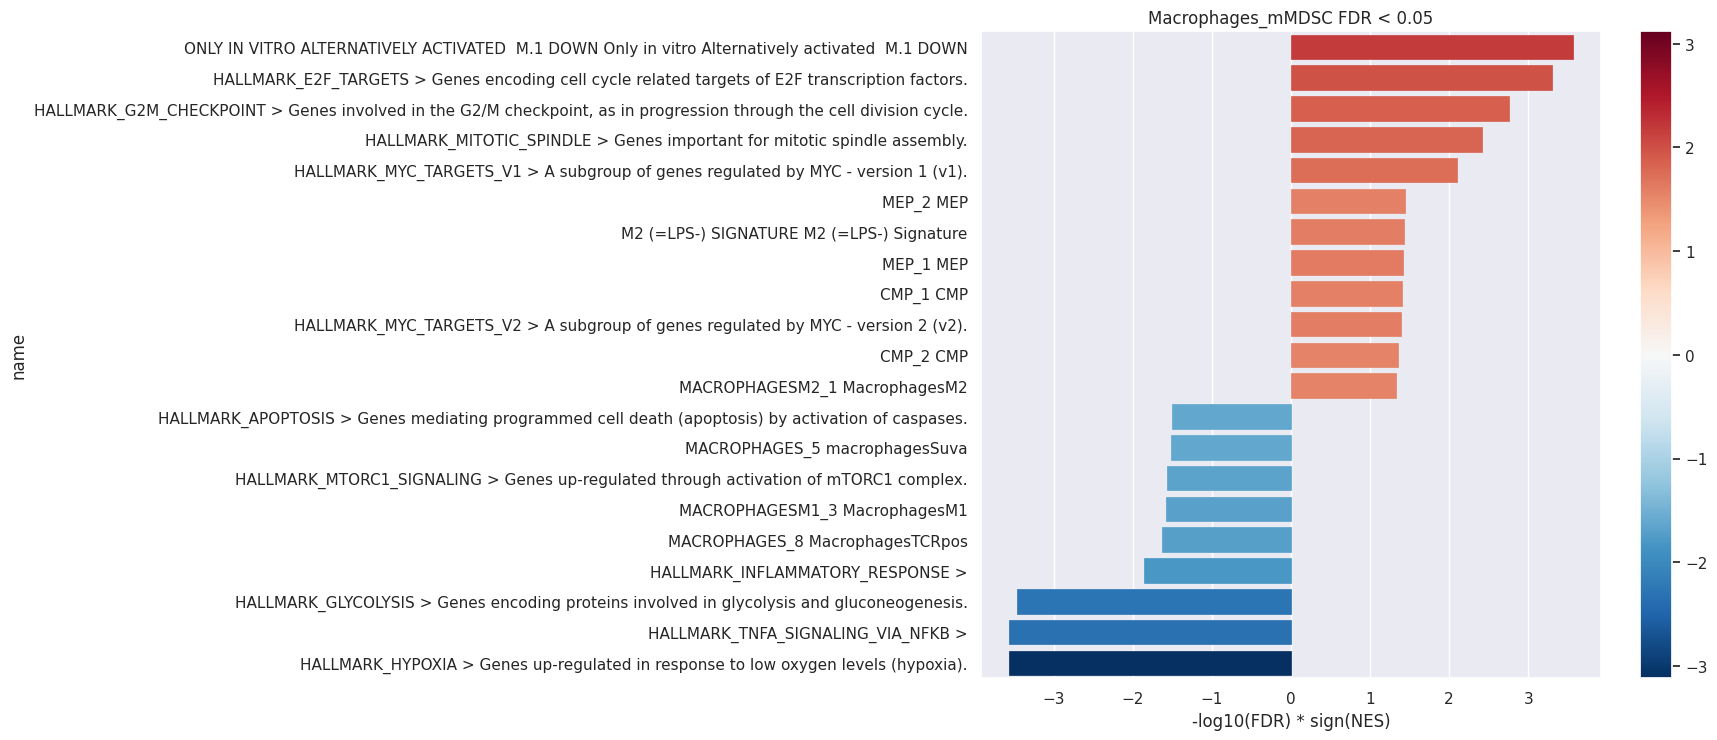

In [90]:
# example plot of GSEA results
fdr_cutoff = 0.05
cellType = 'Macrophages_mMDSC'
f = (dc1_gsea_results['cell type'] == cellType) & (dc1_gsea_results['fdr_q'] < fdr_cutoff)
print(cellType, sum(f))
tmp = dc1_gsea_results.loc[f]
ct0=cellType.replace(' ','_').replace('/','_')
ct.plot_gsea_results(tmp, fdr_cutoff=fdr_cutoff, title=cellType, plot_outfile=f'{outdir}/{cellType}/GSEA-score_fdr{fdr_cutoff}.png',
                     remove_strings=['MONOCYTES'])
plt.show()

## Circos plot

First, make a data frame containing all relevant statistics about ligands and receptors
including numSigInt_fdr05 for receptors, ligand fdr and logFC, and diffusion component values (for sorting them along circle)

This should be filtered to only the ligands/receptors that should be plotted along circle

In [91]:
# combine data about ligands and receptors into one data frame

# Only keep receptors with a minimum number of interaction effects (numSigI1_fdr05 > 0)
# and ligands that interact with these receptors, and are differentially expressed (fdr < 0.05)

# a 'target' refers to a ligand or receptor, some can be both. The columns 'ligand' and 'receptor' are booleans
# set to True if the target is a ligand/receptor
degobs = deg.obs.loc[deg.obs['numSigI1_fdr05'] > 0]
target_stats = diffComp.obs.merge(degobs.rename(columns={'receptor':'target'}), on=['target', 'cell type'],how='outer')
target_stats['receptor'] = ~pd.isna(target_stats['numSigI1_fdr05'])
allReceptors = list(set(target_stats.loc[target_stats['receptor'], 'target']))
allLigands = list(set(interactions.loc[interactions['receptor'].isin(allReceptors),'ligand']))
target_stats['ligand'] = target_stats['target'].isin(allLigands)

target_stats = target_stats.merge(ligandsDE[['gene', 'cell type', 'log2FC', 'fdr']].rename(columns={'gene':'target'}), 
                                  on=['target', 'cell type'], how='left')

# remove ligands that are not DE
f = (target_stats['ligand']) & (target_stats['fdr'] >= 0.05)
f1 = (f) & (target_stats['receptor'])
target_stats.loc[f1,'ligand'] = False
f2 = (f) & (~target_stats['receptor'])
target_stats = target_stats.loc[~f2].reset_index(drop=True)

f = pd.isna(target_stats['numSigI1_fdr05'])
target_stats.loc[f,'numSigI1_fdr05'] = 0


In [92]:
target_stats

,cell type,target,fracExp,cell_type_dc1,cell_type_dc2,cell_type_dc1_norm,absDE,absDE_scaled,numSigI1_fdr05,receptor,ligand,log2FC,fdr
0,B_cells,Apoe,0.550645,1.522370,-0.195329,0.465369,581.302124,0.006894,0.0,False,True,-0.534107,9.386766e-38
1,B_cells,Arf1,0.385303,0.316248,0.647002,0.096673,645.078979,0.007650,0.0,False,True,0.063085,7.574576e-03
2,B_cells,Bsg,0.214002,-0.178962,0.707588,-0.054706,948.494385,0.011248,0.0,False,True,-0.078801,2.282224e-02
3,B_cells,Calm1,0.763654,0.416294,0.597170,0.127256,990.874756,0.011751,0.0,False,True,0.072511,1.566894e-05
4,B_cells,Calr,0.366435,0.002299,0.690244,0.000703,783.534668,0.009292,0.0,False,True,-0.111282,7.491500e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,Tumor_cells,aVb5_complex,0.368189,-2.640844,0.062396,-0.674501,7419.872559,0.087992,3.0,True,False,NaN,NaN
698,cDC,Ccl8,0.089577,-0.526471,-0.125680,-0.207690,1670.366943,0.019809,0.0,False,True,-0.081207,4.754578e-03
699,cDC,S100a8,0.557003,-0.926780,0.235270,-0.365610,1365.670654,0.016195,0.0,False,True,0.330720,1.771924e-08
700,cDC,S100a9,0.500000,-0.921109,0.267313,-0.363373,1398.743652,0.016588,0.0,False,True,0.339517,1.645999e-10


In [93]:
# Show counts of ligands, receptors, some genes are both
target_stats[['ligand', 'receptor']].value_counts()

ligand  receptor
True    False       362
False   True        282
True    True         58
dtype: int64

In [94]:
cellType_colormap = {'B_cells': '#F9D318',
     'Endothelial_cells': '#6B0C0C',
     'Fibroblast_cells': '#216C04',
     'Macrophages_mMDSC': '#0047CF',
     'Mast_cells': '#A16E0F',
     'NK_cells': '#EA0C0C',
     'Osteoclasts': '#8298B0',
     'PMN_gMDSC': '#15EAFB',
     'T_cells': '#F47D08',
     'Tumor_cells': '#A4D10A',
     'cDC': '#C438FB',
     'pDC': '#51119A'}

In [96]:
outdir=f'{output_dir}/circos'
tmp = ct.make_circos_plot(interactions, target_stats,
                          numSigI1_stat='numSigI1_fdr05',
                          links_min_numSigI1=12,
                          links_max_ligand_fdr=0.05,
                          links_min_ligand_absLog2FC=0.15,
                          order_col='cell_type_dc1_norm',
                          outdir=outdir, colorMap=cellType_colormap,
                          cellType_labels=True, cellType_filter_receptor=['Tumor_cells', 'Macrophages_mMDSC'],
                          cellType_filter_ligand='PMN_gMDSC')

Removing 0 rows of target_stats that have cell_type_dc1_norm=NaN
 num_ligand = 420
 num_receptor = 340
Removing 3 cell Types that have no labels: NK_cells,cDC,pDC
target_stats.shape = (694, 15)
Macrophages_mMDSC 259
Tumor_cells 230
PMN_gMDSC 84
T_cells 84
B_cells 29
Fibroblast_cells 5
Osteoclasts 3
Wrote karyotype file with 7 chromosomes and 694 genes
Number of links: : 32
Wrote /workdir/tutorial_output/circos/circos.conf
Done making circos plot /workdir/tutorial_output/circos/circos.png
Placed 35 labels


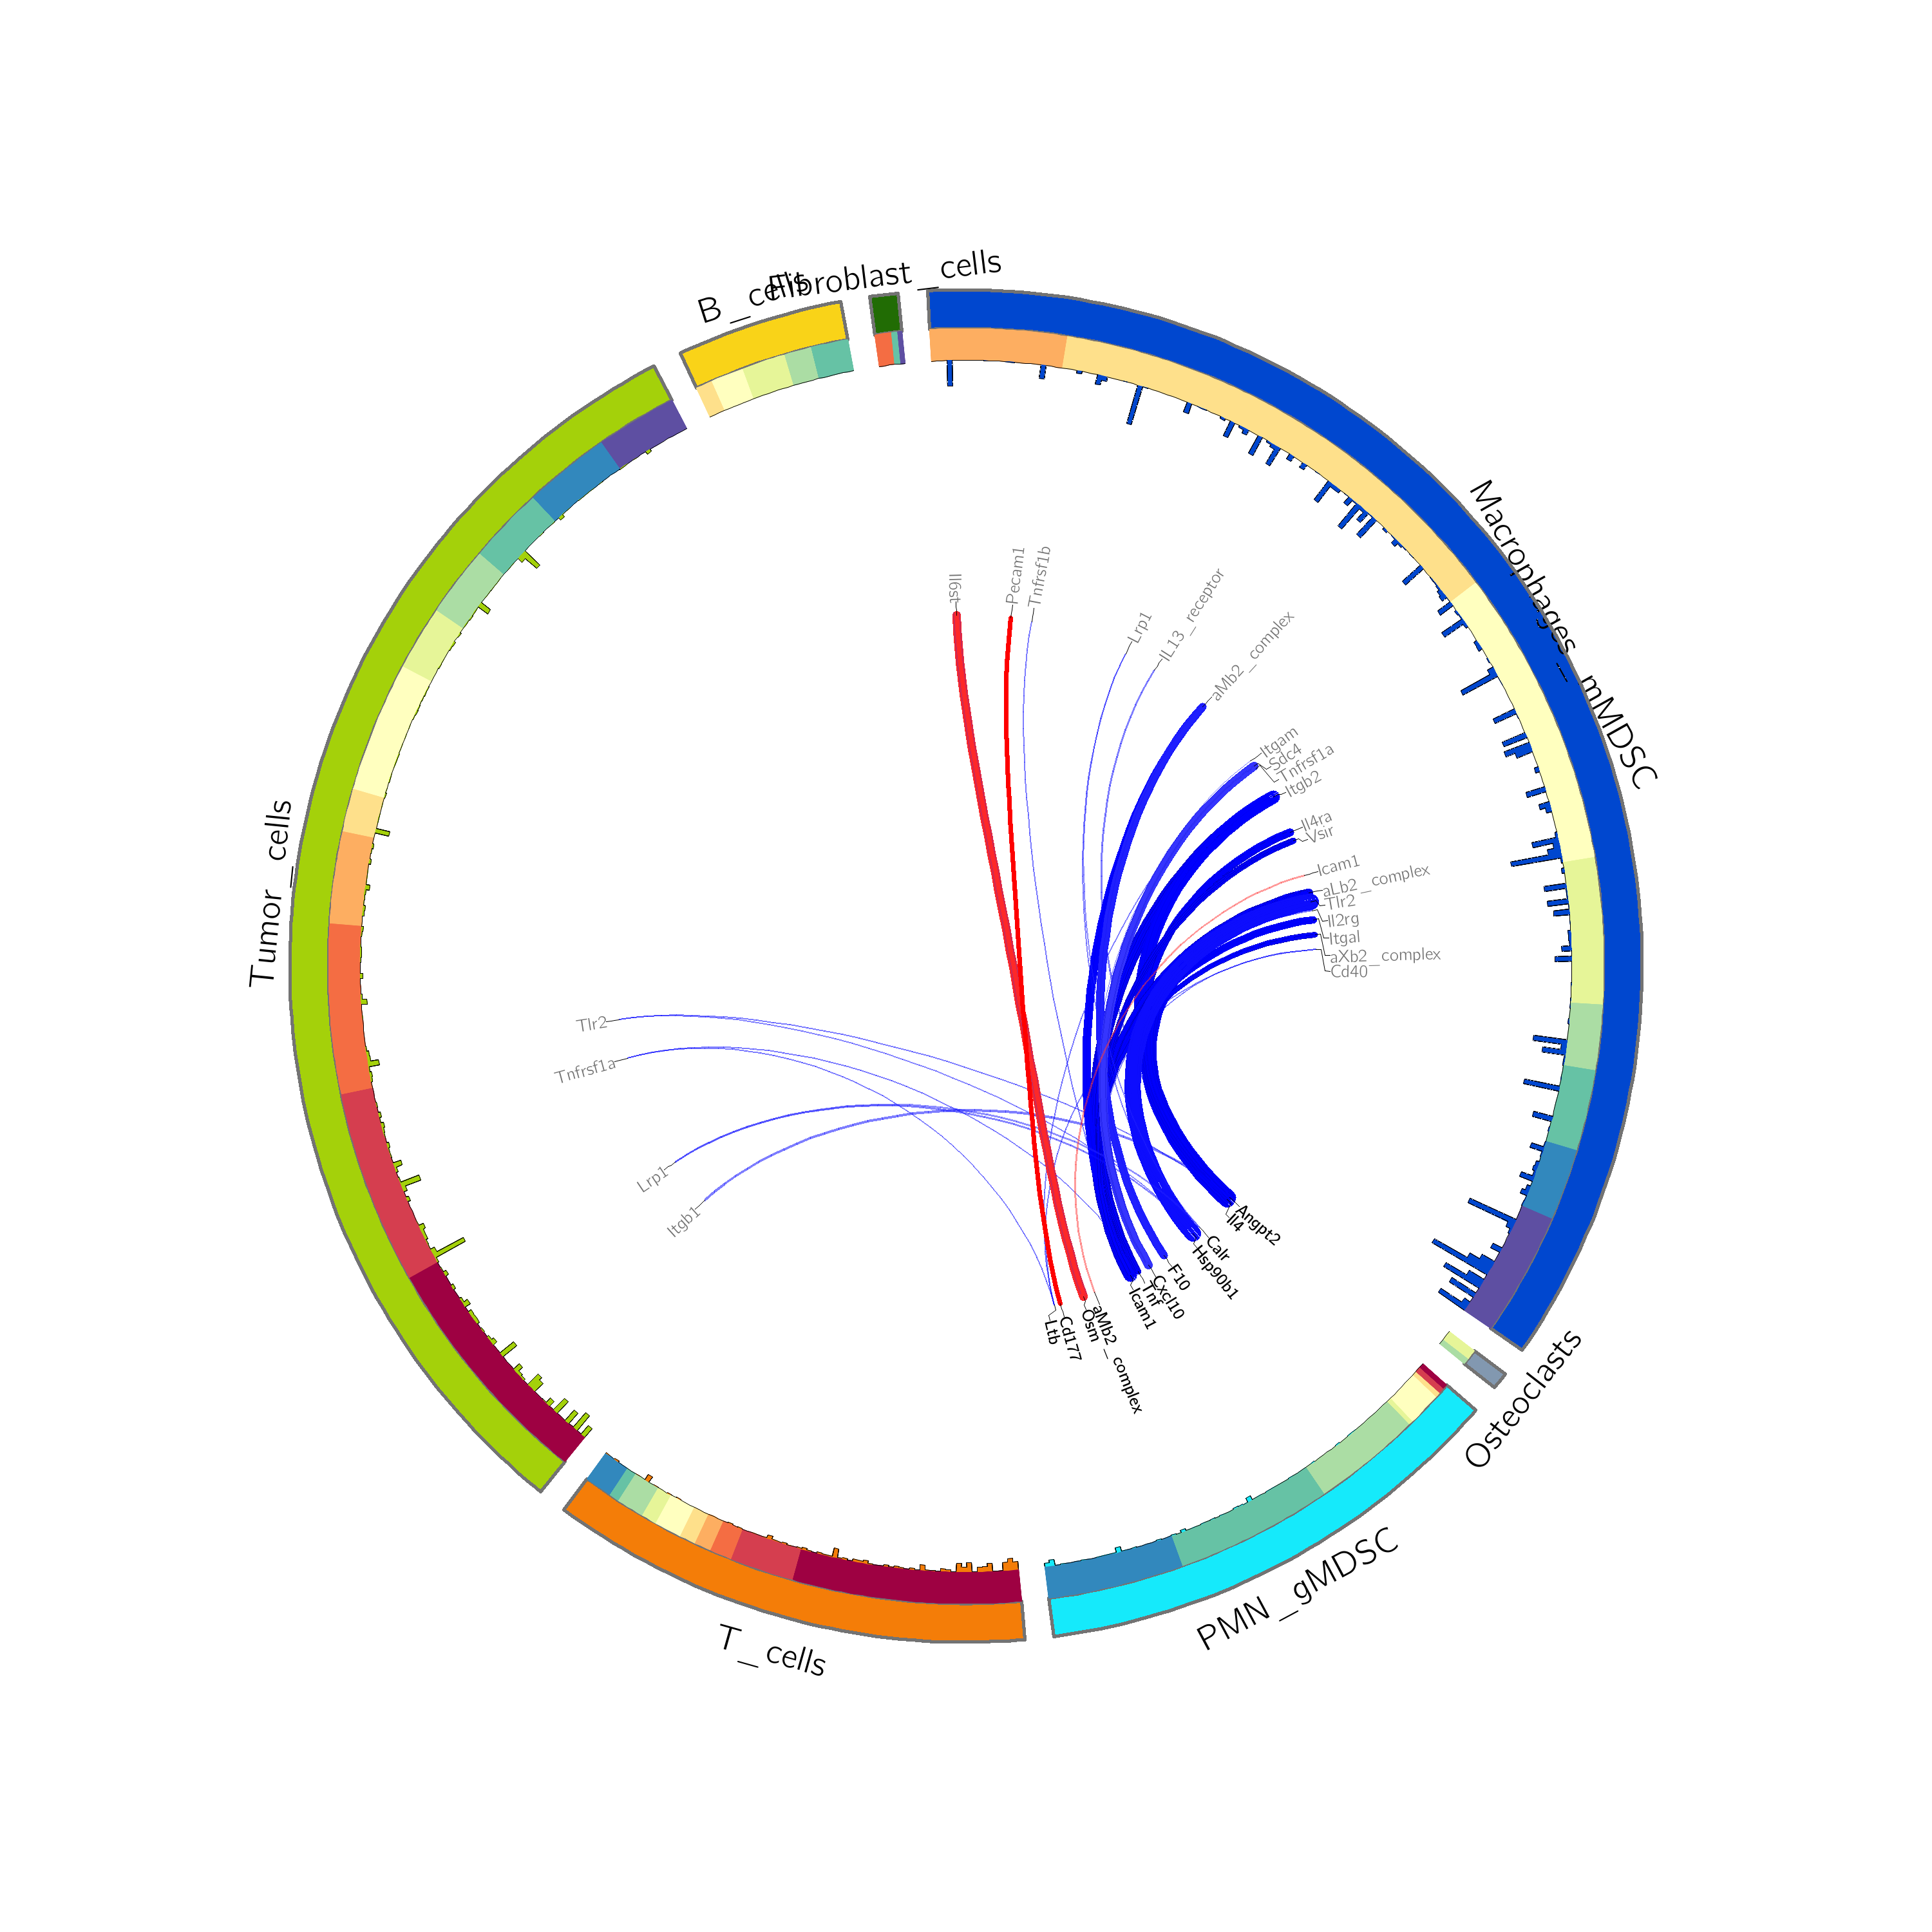

In [97]:
Image(f'{outdir}/circos.png')

In [98]:
outdir=f'{output_dir}/circos_all'
tmp = ct.make_circos_plot(interactions, target_stats,
                          numSigI1_stat='numSigI1_fdr05',
                          links_min_numSigI1=12,
                          links_max_ligand_fdr=0.05,
                          links_min_ligand_absLog2FC=0.15,
                          order_col='cell_type_dc1_norm',
                          outdir=outdir, colorMap=cellType_colormap)

Removing 0 rows of target_stats that have cell_type_dc1_norm=NaN
 num_ligand = 420
 num_receptor = 340
Removing 3 cell Types that have no labels: NK_cells,cDC,pDC
target_stats.shape = (694, 15)
Macrophages_mMDSC 259
Tumor_cells 230
PMN_gMDSC 84
T_cells 84
B_cells 29
Fibroblast_cells 5
Osteoclasts 3
Wrote karyotype file with 7 chromosomes and 694 genes
Number of links: : 191
Wrote /workdir/tutorial_output/circos_all/circos.conf
Done making circos plot /workdir/tutorial_output/circos_all/circos.png
Placed 122 labels


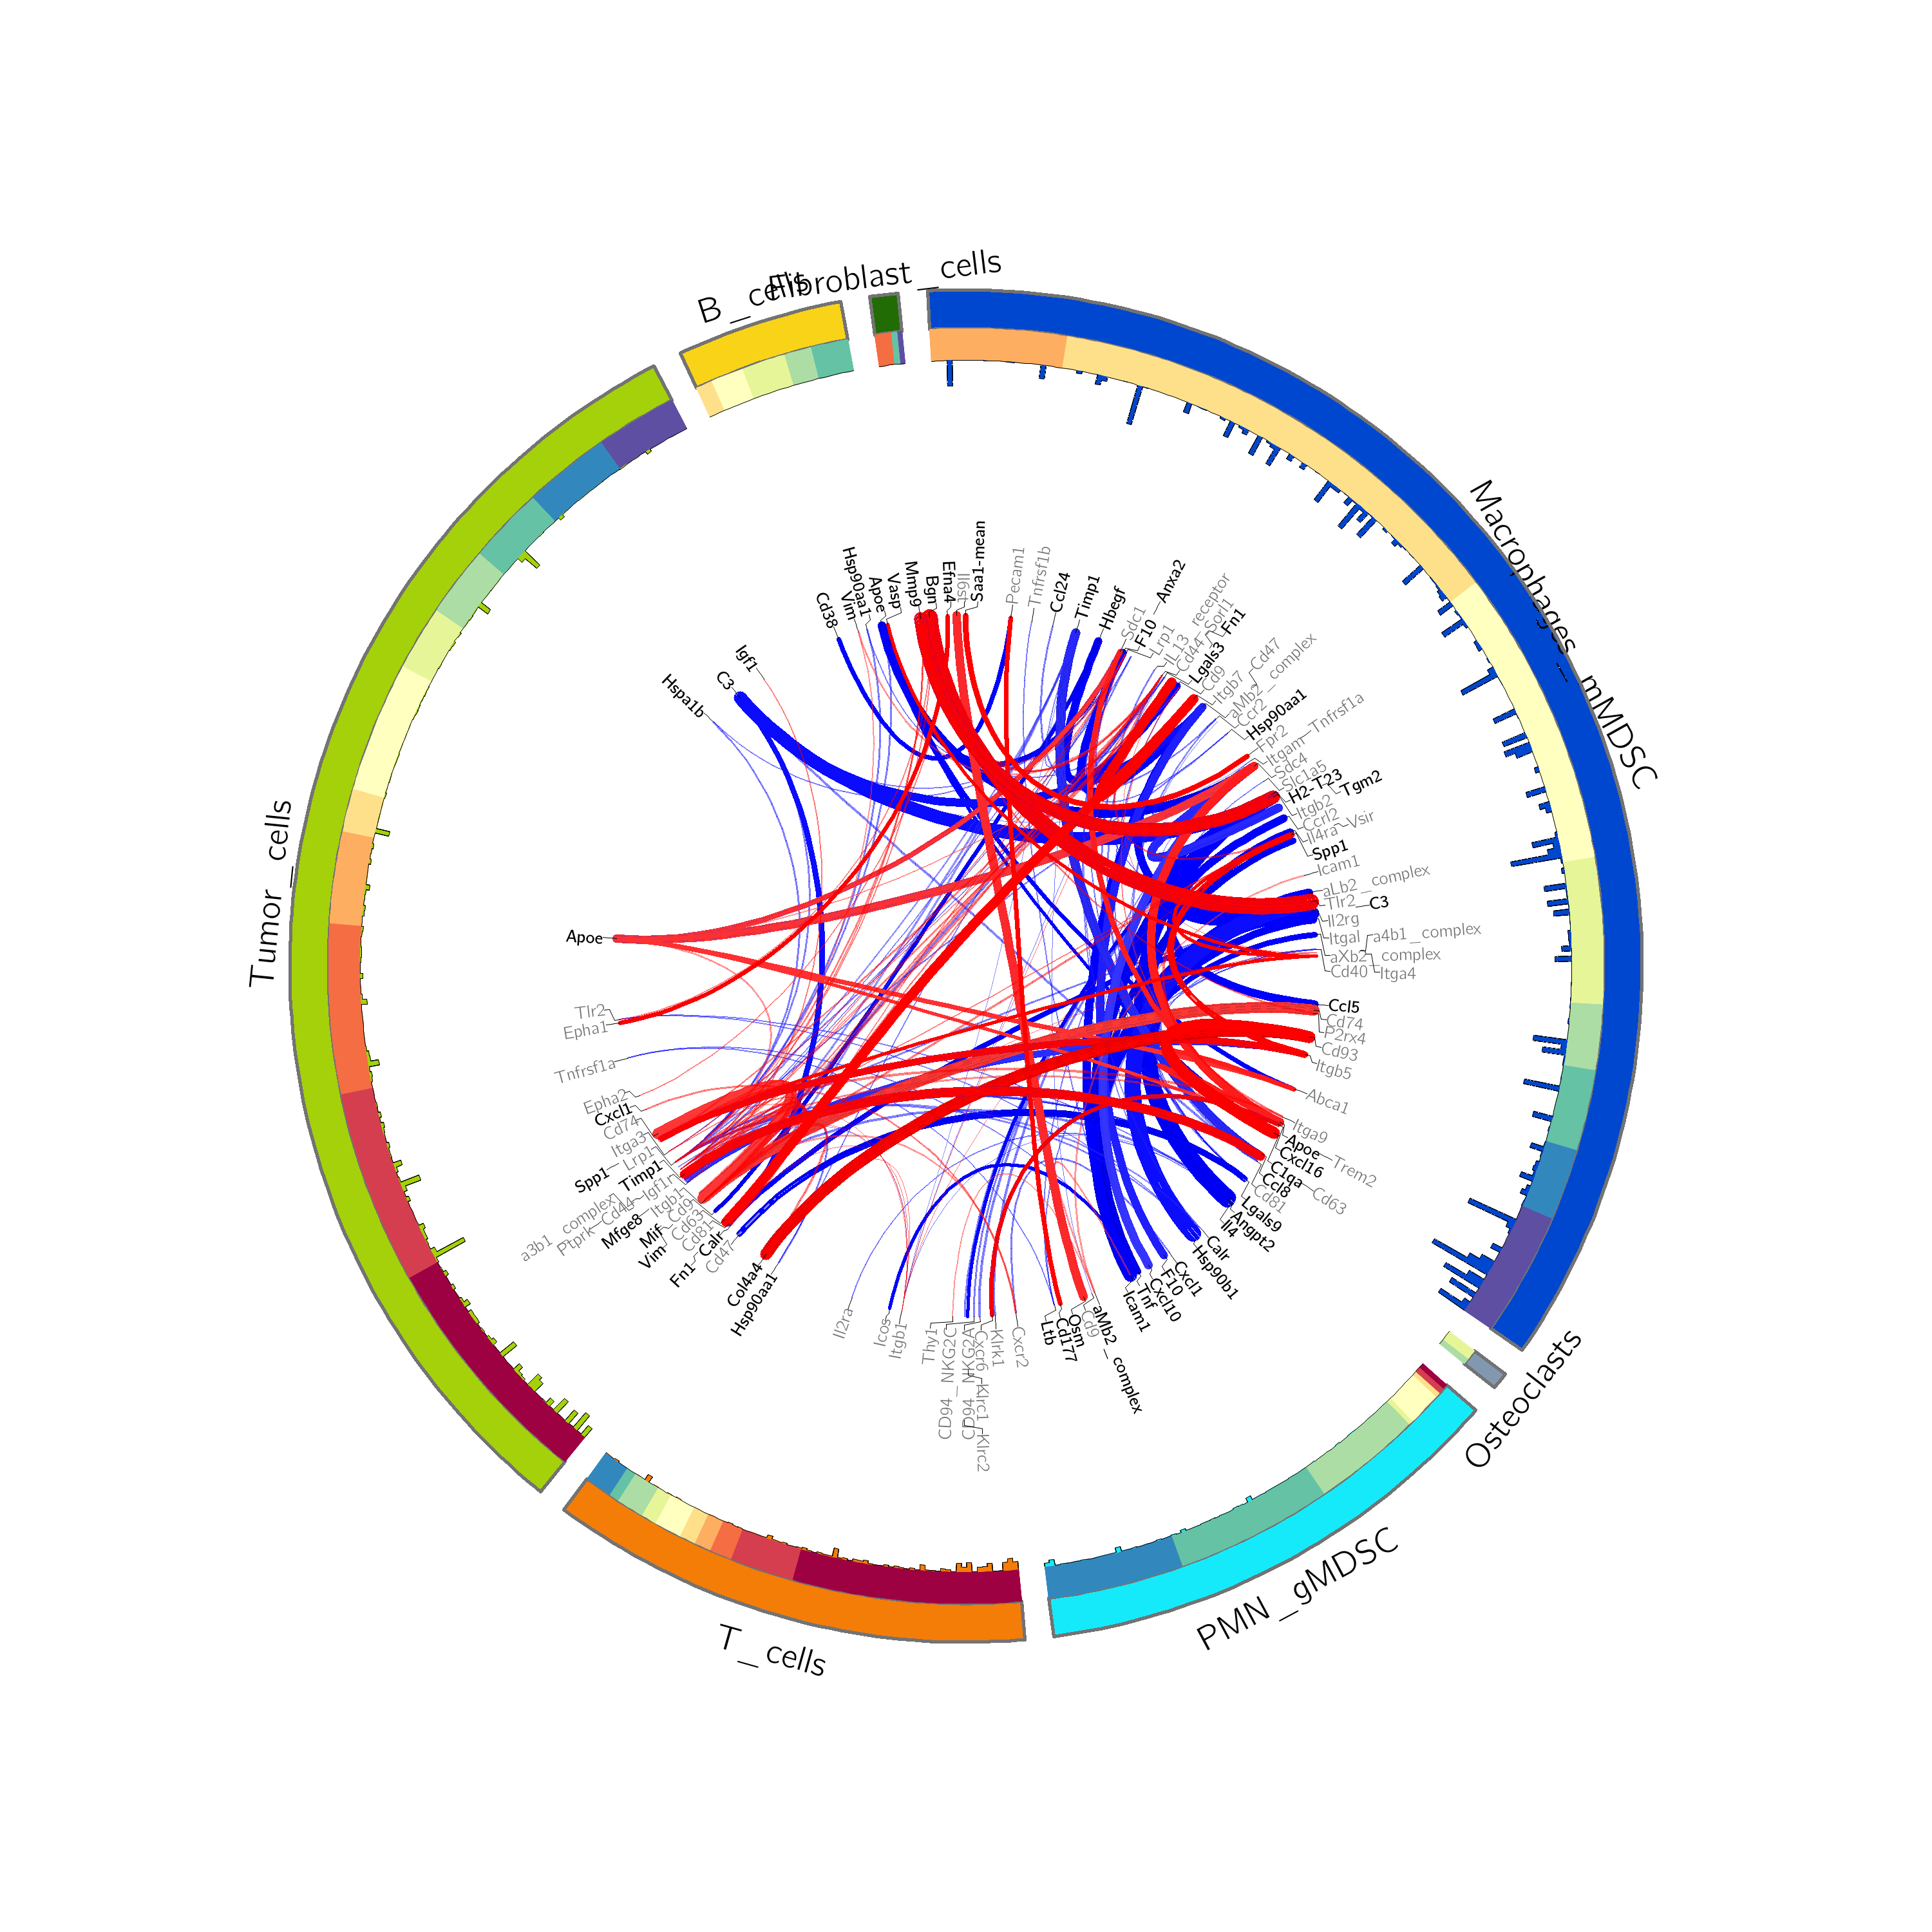

In [99]:
Image(f'{outdir}/circos.png')